In [2]:
NO_VISUALS = True

In [3]:
# %run '01.06.25._17_Models.ipynb'

**0. Installing Dependencies**

In [4]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels dash -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
file_paths = [
    '../../Data/EnergieUebersichtCH-2022.xlsx',
    '../../Data/EnergieUebersichtCH-2023.xlsx',
    '../../Data/EnergieUebersichtCH-2024.xlsx',
    '../../Data/EnergieUebersichtCH-2025.xlsx',
]
sheet_name = 'Zeitreihen0h15'
total = 29000

**1. Retrieving Data**

In [6]:
import pandas as pd

In [7]:
if 'dfs_loaded' not in globals():
    dfs = []
    for path in file_paths:
        xls = pd.ExcelFile(path)
        df_year = pd.read_excel(xls, sheet_name=sheet_name, header=1)
        dfs.append(df_year)
    dfs_loaded = True 


Combining all years into a single DataFrame

In [8]:
df = pd.concat(dfs, ignore_index=True)
print(df.columns)

Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


In [9]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

II. Data Cleaning

In [10]:
import plotly.express as px

df.loc[df['Total Energy Consumption (kWh)'].isna(), 'color'] = 'Total Energy Consumption'

# Mask for rows with any NA values
mask = df.isna().any(axis=1)
df_missing = df[mask].copy()
df_missing['is_missing'] = True  # optional for consistent y-axis

# Scatter plot
fig = px.scatter(
    data_frame=df_missing,
    x=df_missing.index,
    y='is_missing',
    color='color',
    title='Scatterplot of the empty loads (Actual)',
    labels={'x': 'Date', 'is_missing': 'Missing Entry', 'color': ''}
)
fig.show()


Is each index unique?

In [11]:
df.index.is_unique

True

Check min, max, std for anomalies

In [12]:
print(df.describe()) 

       Total Energy Consumed by End Users (kWh)  \
count                              1.138520e+05   
mean                               1.557924e+06   
std                                2.965795e+05   
min                                8.924723e+05   
25%                                1.326569e+06   
50%                                1.545676e+06   
75%                                1.751344e+06   
max                                2.399117e+06   

       Total Energy Production (kWh)  Total Energy Consumption (kWh)  \
count                   1.138520e+05                    1.138520e+05   
mean                    1.925989e+06                    1.803166e+06   
std                     5.695668e+05                    2.656051e+05   
min                     8.139795e+05                    1.038507e+06   
25%                     1.471829e+06                    1.626075e+06   
50%                     1.792088e+06                    1.808781e+06   
75%                     2.304247e+06

1.1 Aggregate Data by day

In [13]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)


In [14]:
df = df.set_index('Zeitstempel')
df = df.resample('7D').sum()

Recalculate total by 24h

In [15]:
total = int ((total / 96) -1) 
print(total)

301


In [16]:
time_index = df.index

Save backup 

In [17]:
df_backup = df

**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [18]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

In [19]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].values

In [20]:
import matplotlib.pyplot as plt

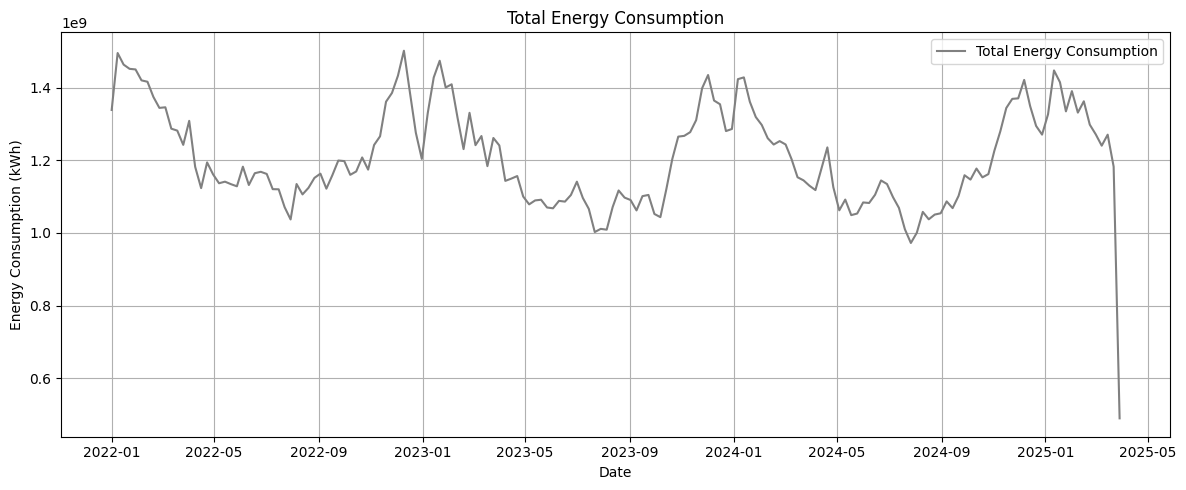

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
ax.set_title('Total Energy Consumption')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# III: Time Series Analysis 

**III. 1.Determening Outliers**

The last element of the time series is an outlier, it's an incomplete sum

In [22]:
df = df[:-1]

We then recompute our time_series

In [23]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values

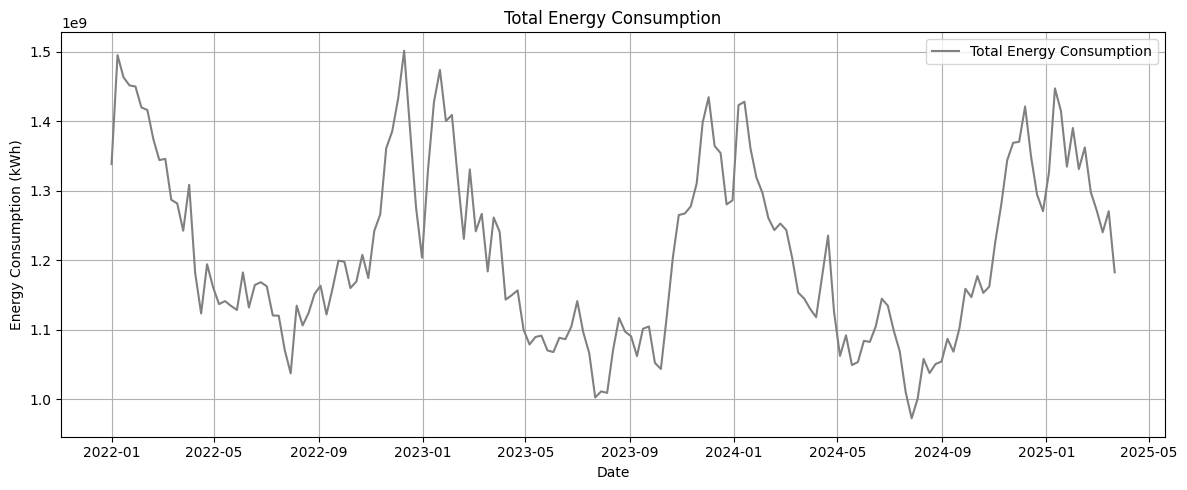

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
ax.set_title('Total Energy Consumption')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

**III. 1. Stationarity of my Time Series**

Formal checks will be added in next chapters

To-do: forecast par semaine, dépend de swissgrid, 

Ecrire chaque concept dans le rapport

graph de xt+i - xt

**III. 1.a. Informal check**

# III. 1.a. i. Mean Calculation

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

In [25]:
def mean(data):
    return sum(data) / len(data)

In [26]:
print(mean(energy_consumption_data))

1211859373.575151


In [27]:
def sliced_mean_calculator(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices

In [28]:
mean_window_size = len(energy_consumption_data) // 10

In [29]:
means, time_indices = sliced_mean_calculator(energy_consumption_data,time_index, mean_window_size)

Plotting Mean over time

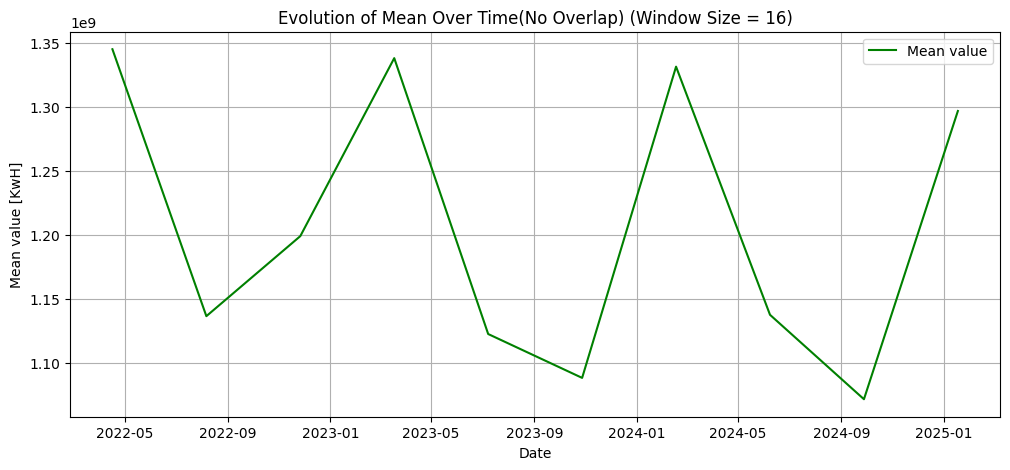

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', label='Mean value')
plt.xlabel('Date')
plt.ylabel('Mean value [KwH]')
plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
energy_consumption_data[0] = means[0]
energy_consumption_data[-1] = means[-1]

# III. 1.a. ii. Variance Calculation

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

In [32]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance

In [33]:
print(variance(energy_consumption_data))

1.615468325546781e+16


Plotting variance over time

In [34]:
total_length =  len(energy_consumption_data)
variance_window_size = total_length // 10

In [35]:
print(variance_window_size)

16


Defining variance, time arrays

In [36]:
def sliced_variances_calculator(data, time_index,variance_window_size):
    variances = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = variance(window_slice)
        variances.append(var)
        time_indices.append(time_index[i + variance_window_size - 1]) 
    return variances, time_indices


In [37]:
variances, time_indices = sliced_variances_calculator(energy_consumption_data,time_index, variance_window_size)

In [38]:
print(variances, time_indices)

[1.033746772656051e+16, 1456728727874709.0, 5986355161905390.0, 9112731182103640.0, 3102778828753499.5, 4454099875064055.0, 3851265094256801.0, 4332208286382734.5, 2542369177531297.5, 9382294175306716.0] [Timestamp('2022-04-16 00:00:00'), Timestamp('2022-08-06 00:00:00'), Timestamp('2022-11-26 00:00:00'), Timestamp('2023-03-18 00:00:00'), Timestamp('2023-07-08 00:00:00'), Timestamp('2023-10-28 00:00:00'), Timestamp('2024-02-17 00:00:00'), Timestamp('2024-06-08 00:00:00'), Timestamp('2024-09-28 00:00:00'), Timestamp('2025-01-18 00:00:00')]


Plotting Variance over time

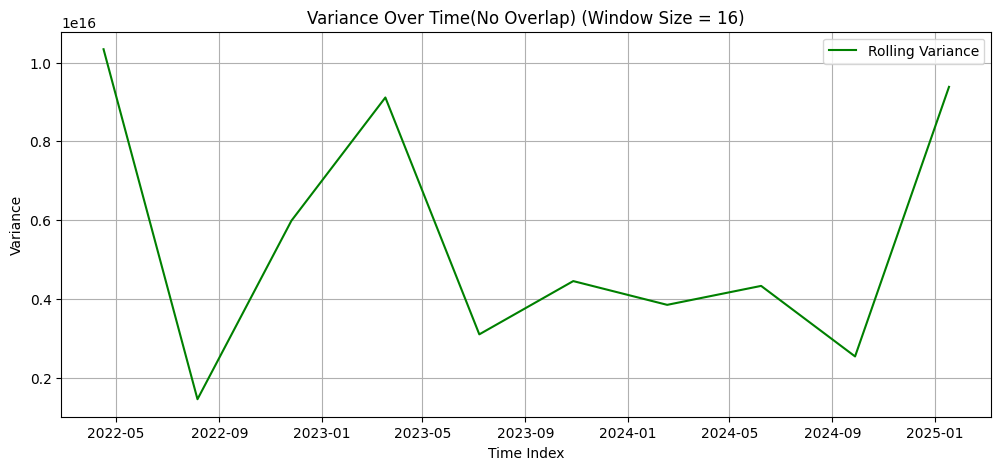

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, variances, color='green', label='Rolling Variance')
plt.xlabel('Time Index')
plt.ylabel('Variance')
plt.title(f'Variance Over Time(No Overlap) (Window Size = {variance_window_size})')
plt.grid(True)
plt.legend()
plt.show()

**III. 1.a. iii. Autocorrelation Calculation**

In [40]:
from statsmodels.tsa.stattools import acf

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
ro k = ck/ c0 where ck is the autocovariance at lag k

In [41]:
alpha = 0.05
confint = 1 - alpha
nlags = 52

In [42]:
import numpy as np

In [43]:
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha) 
    return acf_vals


In [44]:
acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)

In [45]:
print(f"High Autocorrelation defined as {1 - alpha}")
for lag in range(1, nlags + 1):
    print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.9142
lag  2 → ACF =  0.8146
lag  3 → ACF =  0.7344
lag  4 → ACF =  0.6688
lag  5 → ACF =  0.6155
lag  6 → ACF =  0.5598
lag  7 → ACF =  0.5023
lag  8 → ACF =  0.4198
lag  9 → ACF =  0.3404
lag 10 → ACF =  0.2552
lag 11 → ACF =  0.1644
lag 12 → ACF =  0.0603
lag 13 → ACF = -0.0317
lag 14 → ACF = -0.1149
lag 15 → ACF = -0.1759
lag 16 → ACF = -0.2514
lag 17 → ACF = -0.3218
lag 18 → ACF = -0.3598
lag 19 → ACF = -0.4067
lag 20 → ACF = -0.4273
lag 21 → ACF = -0.4487
lag 22 → ACF = -0.4674
lag 23 → ACF = -0.5021
lag 24 → ACF = -0.5434
lag 25 → ACF = -0.5738
lag 26 → ACF = -0.5986
lag 27 → ACF = -0.5979
lag 28 → ACF = -0.5764
lag 29 → ACF = -0.5266
lag 30 → ACF = -0.4829
lag 31 → ACF = -0.4529
lag 32 → ACF = -0.4342
lag 33 → ACF = -0.4005
lag 34 → ACF = -0.3698
lag 35 → ACF = -0.3248
lag 36 → ACF = -0.2646
lag 37 → ACF = -0.1990
lag 38 → ACF = -0.1225
lag 39 → ACF = -0.0558
lag 40 → ACF =  0.0337
lag 41 → ACF =  0.1136
lag 42 → ACF =  0.18

Setting axis at 0

There’s no point in computing the correlogram for a visibly non-stationary series—consider only
the stationary portion of the temperature data in the next plot. (Boris). I will then difference my TS then apply ACF.

In [46]:
from darts import TimeSeries

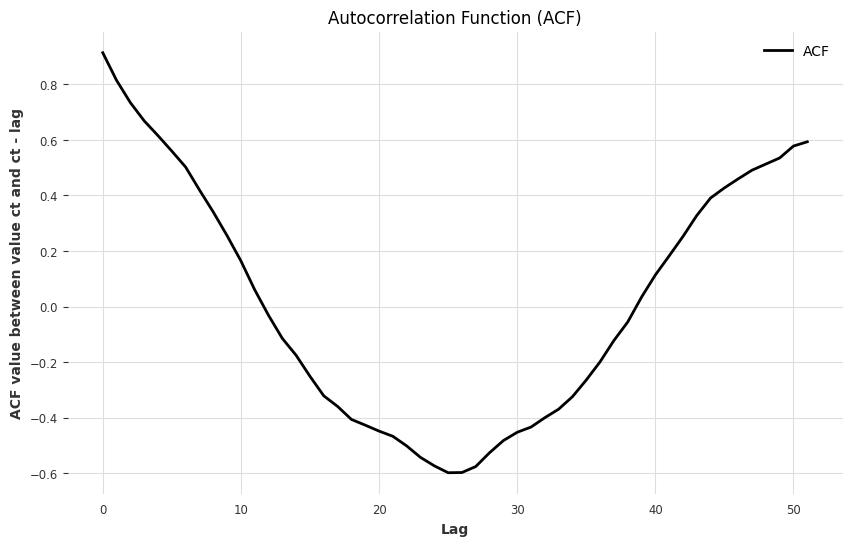

In [47]:
acf_series = TimeSeries.from_values(acf_vals[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value between value ct and ct - lag")
plt.legend(loc="upper right")
plt.show()

PACF: I calculated PACF starting from the ACF Function

After calculating the autocovariance vector, I'm going to use Yule-Walker Modified Method to calculate the PACF vector

This is given by the formula R . ϕ = r where R is the Yule-Walker matrix , r is the ACF vector, ϕ is the PACF vector we're looking for

In [48]:
from scipy.linalg import toeplitz

In [49]:
def pacf_yule_walker_full(gamma: np.ndarray, nlags: int):
    pacf_vals = []
    for k in range(1, nlags + 1):
        R = toeplitz(gamma[:k])          
        r = gamma[1:k+1]                 # r_k: γ(1) to γ(k)
        phi = solve(R, r)                # Solving for R * phi = r
        pacf_vals.append(phi[-1])      
    return np.array(pacf_vals)
from numpy.linalg import solve

In [50]:
pacf_phi_vector = pacf_yule_walker_full(acf_vals, nlags=nlags)

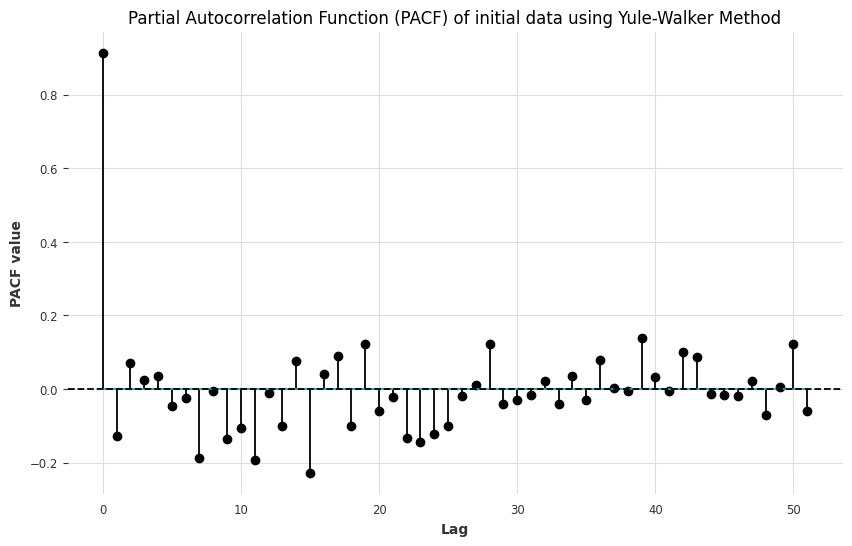

In [51]:
lags = np.arange(len(pacf_phi_vector))  
pacf_vals = pacf_phi_vector
plt.figure(figsize=(10, 6))
plt.stem(lags, pacf_vals)
plt.axhline(0, color='black', linestyle='--')
plt.title("Partial Autocorrelation Function (PACF) of initial data using Yule-Walker Method")
plt.xlabel("Lag")
plt.ylabel("PACF value")
plt.grid(True)
plt.show()


In [52]:
from darts.utils.statistics import (
    remove_trend,
    plot_acf,
    plot_pacf,
)

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF) of initial data using Darts')

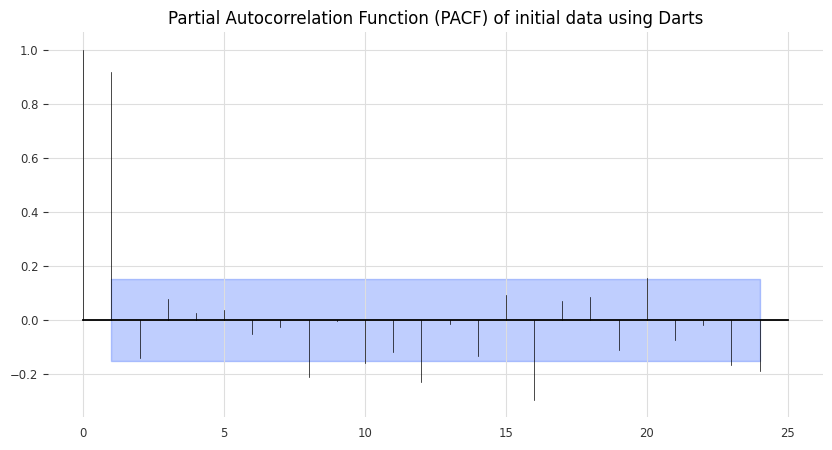

In [53]:
plot_pacf(TimeSeries.from_values(energy_consumption_data))
plt.title("Partial Autocorrelation Function (PACF) of initial data using Darts")  

# B. Differencing

Differencing is a simple approach to removing trends. No need to estimate parameters.

Dt = yt - y(t-1)

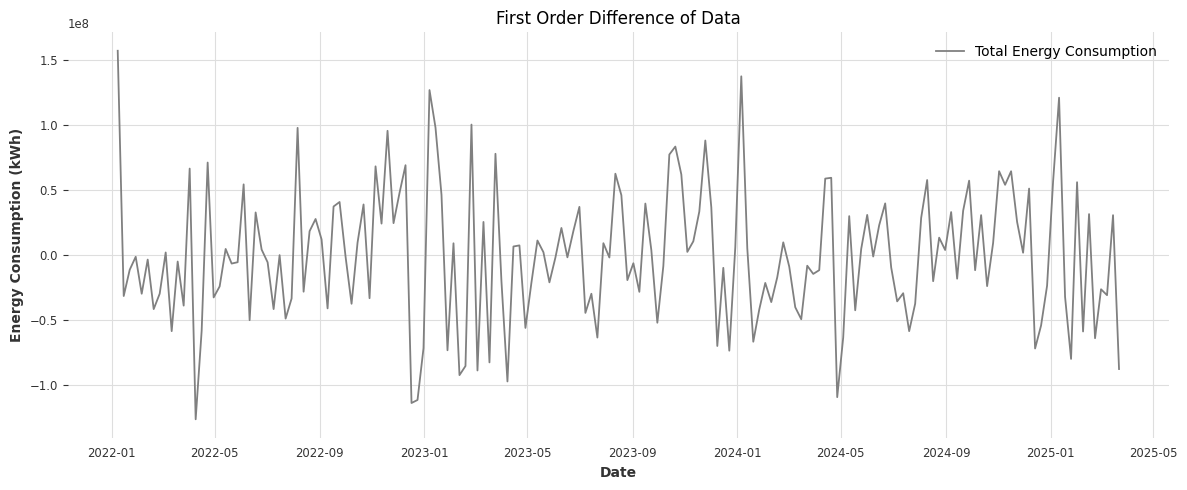

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
first_order_diff = df['Total Energy Consumption (kWh)'].diff()
ax.plot(first_order_diff, label='Total Energy Consumption', color='gray')
ax.set_title('First Order Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Second Order Differencing

Formula for Second Order Diff:

D2Yt = D(D((Yt)) = D (Yt - Yt-1) = D(Yt) - D(Yt-1) = Yt - 2Yt-1 + Yt+2

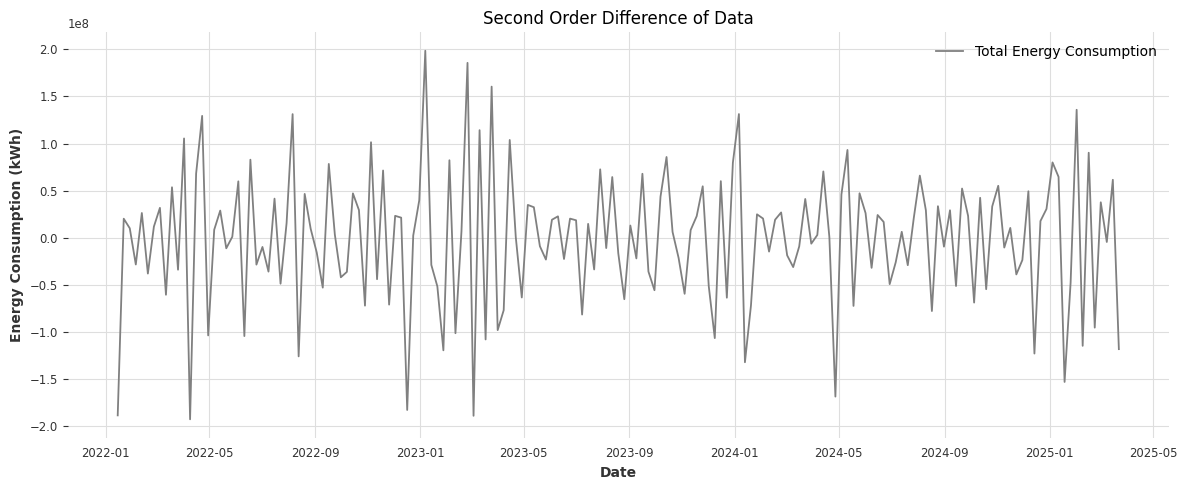

In [55]:
fig, ax = plt.subplots(figsize=(12, 5))
df_2_difference = first_order_diff.diff()
ax.plot(df_2_difference, label='Total Energy Consumption', color='gray')
ax.set_title('Second Order Diﬀerence of Data')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

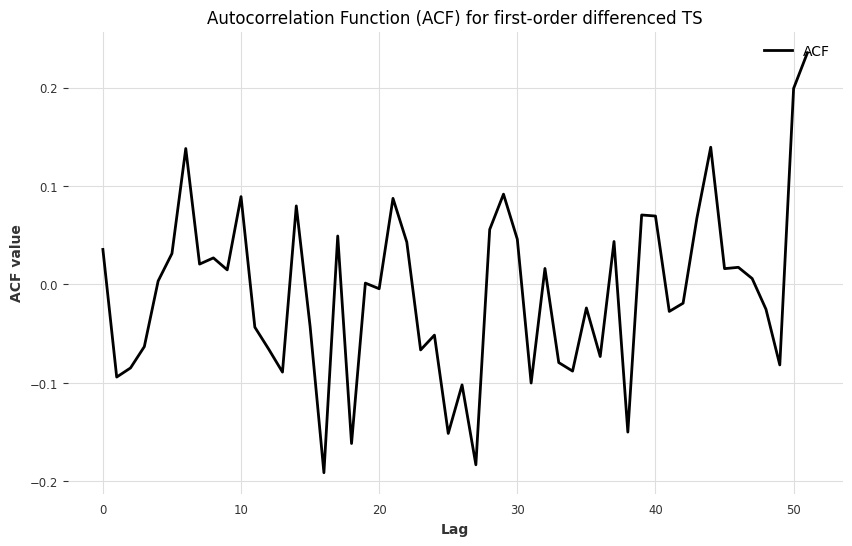

In [56]:
acf_vals_1 = check_autocorrelation(first_order_diff.dropna(), nlags=nlags)
acf_series = TimeSeries.from_values(acf_vals_1[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF) for first-order differenced TS")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.legend(loc="upper right")
plt.show()

This suggests seasonality with a period of 5, as in 5 weeks

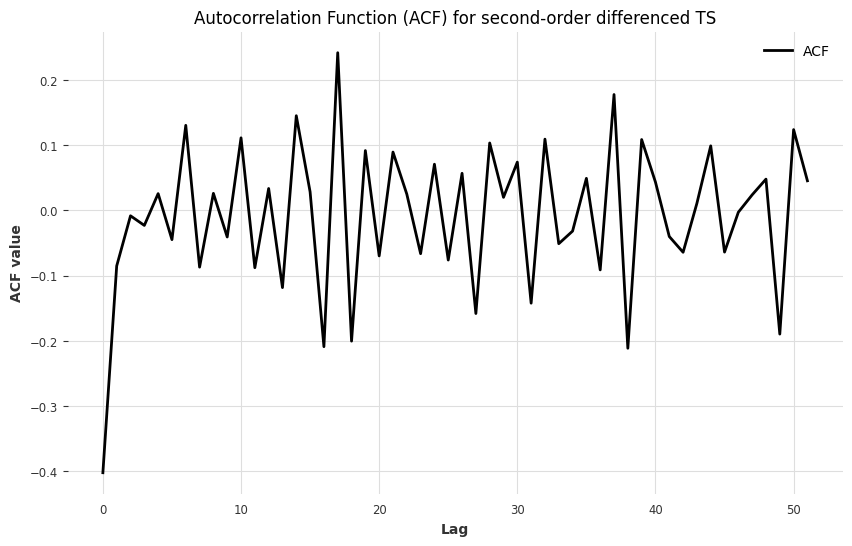

In [57]:
acf_vals_2 = check_autocorrelation(df_2_difference.dropna(), nlags=nlags)
acf_series = TimeSeries.from_values(acf_vals_2[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF) for second-order differenced TS")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.legend(loc="upper right")
plt.show()

Detrending is not enough to make TS stationnary

In [58]:
seasonal_diff = df_2_difference.diff(7).dropna()
seasonal_diff_series = TimeSeries.from_values(df_2_difference.diff(7).dropna())

In [59]:
from darts.utils.statistics import (
    remove_trend,
    stationarity_test_adf,
    stationarity_test_kpss,
    plot_acf,
)

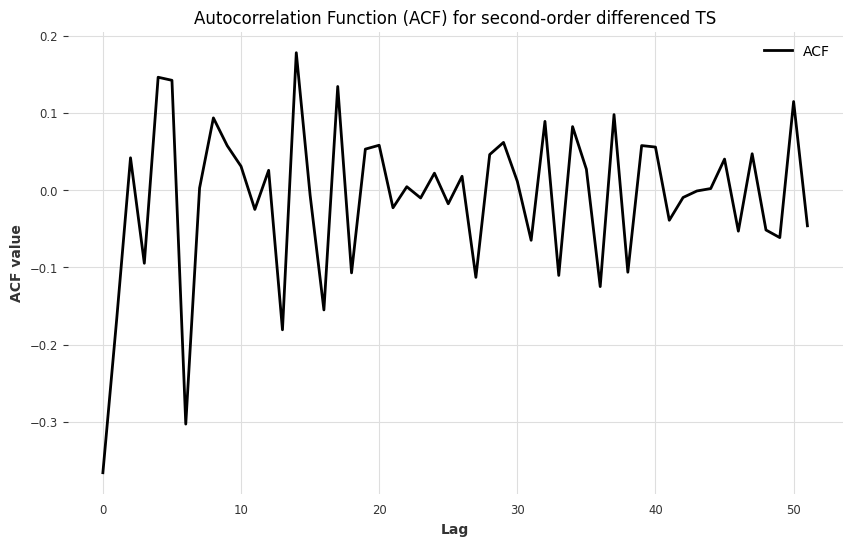

In [60]:
acf_vals_3 = check_autocorrelation(seasonal_diff, nlags=nlags)
acf_series = TimeSeries.from_values(acf_vals_3[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF) for second-order differenced TS")
plt.xlabel("Lag")
plt.ylabel("ACF value")
plt.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'ACF of Differenced Series')

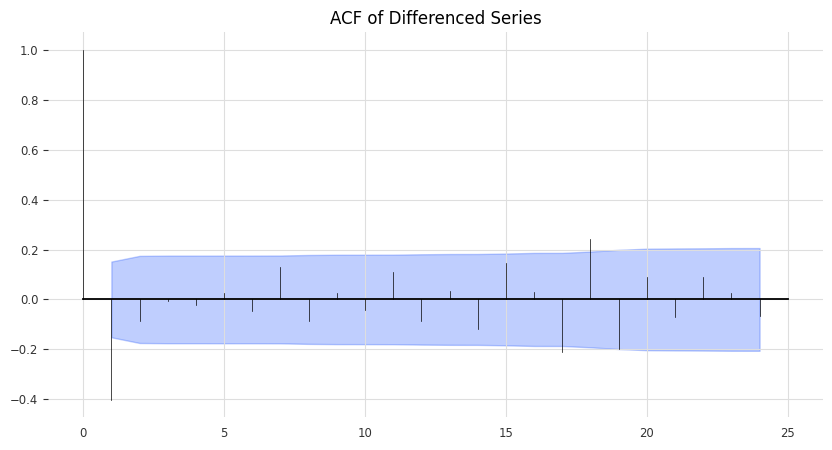

In [61]:
plot_acf(TimeSeries.from_values(df_2_difference.dropna()))
plt.title("ACF of Differenced Series")


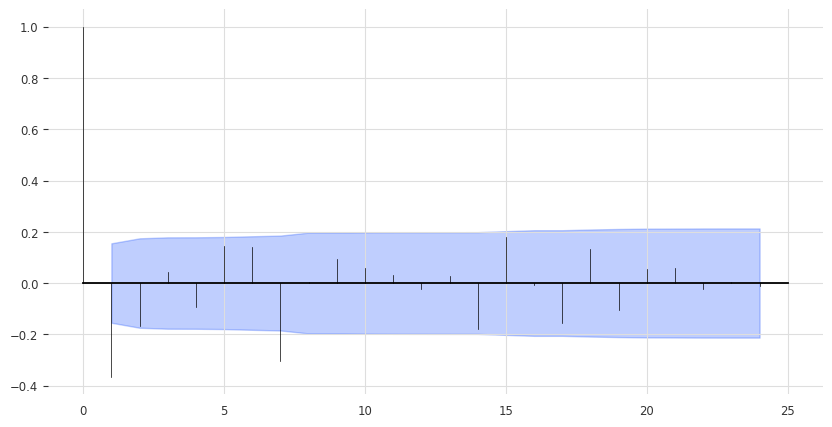

In [62]:
plot_acf(seasonal_diff_series)

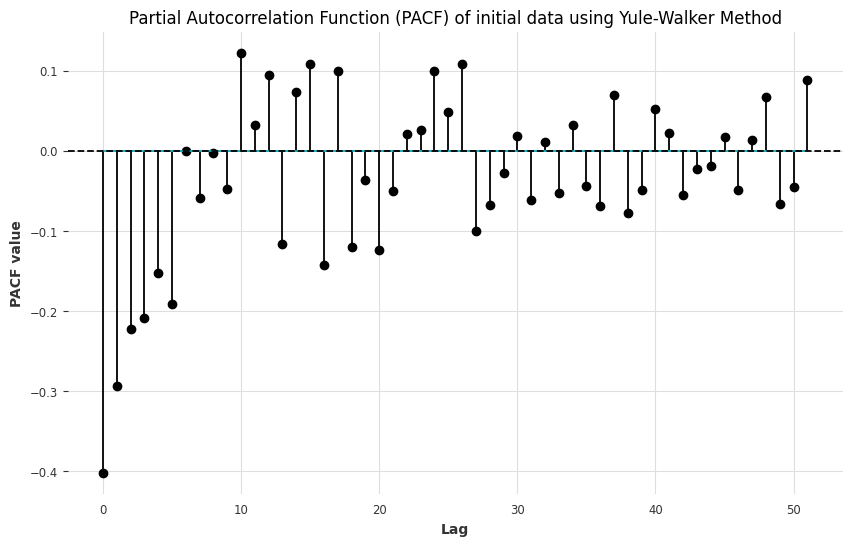

In [63]:
acf_vals = check_autocorrelation(df_2_difference.dropna(), nlags=nlags)
pacf_phi_vector = pacf_yule_walker_full(acf_vals, nlags=nlags)
lags = np.arange(len(pacf_phi_vector))  
pacf_vals = pacf_phi_vector
plt.figure(figsize=(10, 6))
plt.stem(lags, pacf_vals)
plt.axhline(0, color='black', linestyle='--')
plt.title("Partial Autocorrelation Function (PACF) of initial data using Yule-Walker Method")
plt.xlabel("Lag")
plt.ylabel("PACF value")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'PACF of Differenced Series')

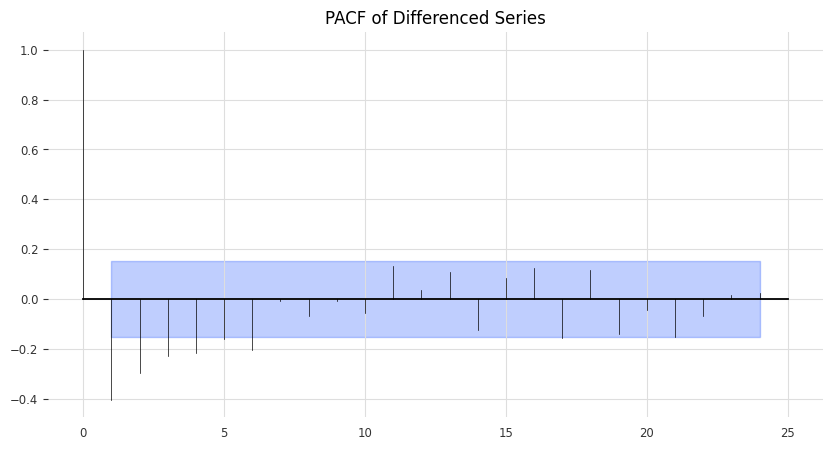

In [64]:
plot_pacf(TimeSeries.from_values(df_2_difference.dropna()))
plt.title("PACF of Differenced Series")

Text(0.5, 1.0, 'PACF of Differenced Series')

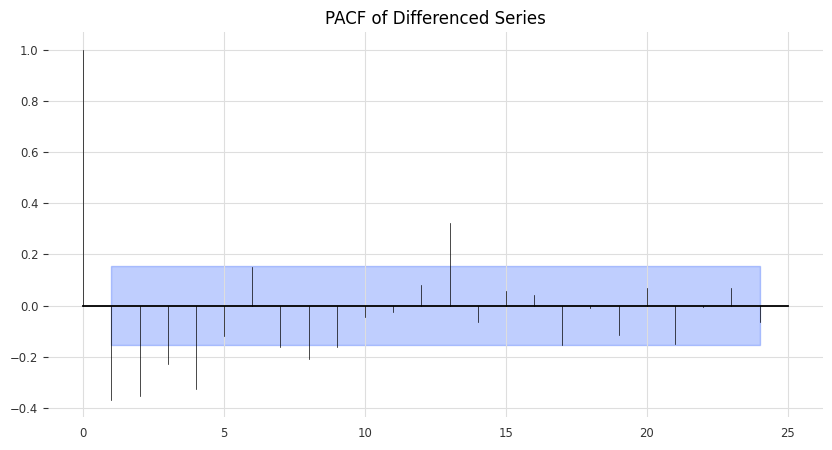

In [65]:
plot_pacf(seasonal_diff_series)
plt.title("PACF of Differenced Series")

Text(0.5, 1.0, 'ACF of Differenced Series')

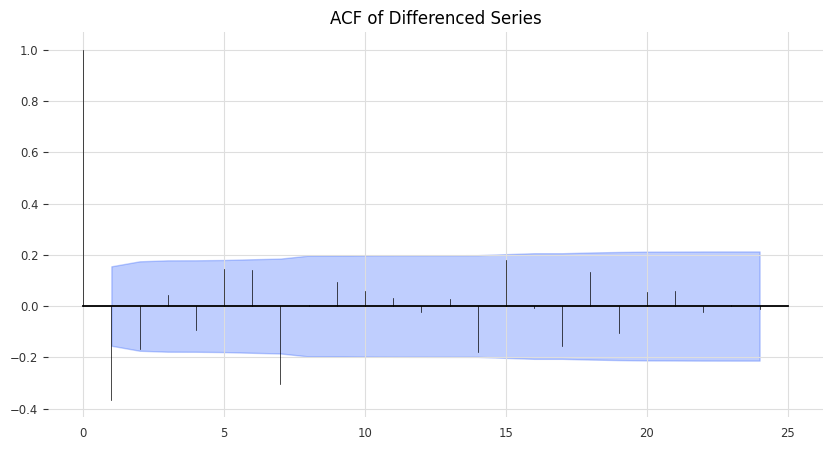

In [66]:
plot_acf(seasonal_diff_series)
plt.title("ACF of Differenced Series")

In [67]:
from statsmodels.stats.diagnostic import acorr_ljungbox

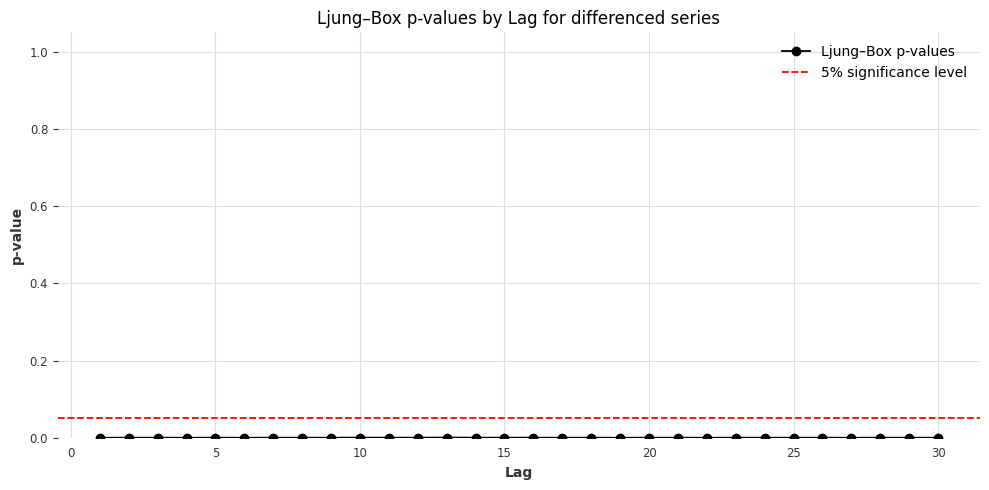

In [68]:
# Convert your residual TimeSeries (e.g., seasonal_diff_series) to a flat NumPy array
residual_array = df_2_difference
residual_array = residual_array[~np.isnan(residual_array)]  # Remove NaNs

# Run Ljung-Box test for multiple lags
max_lag = 30
ljungbox_results = acorr_ljungbox(residual_array, lags=range(1, max_lag + 1), return_df=True)

# Extract p-values
p_values = ljungbox_results['lb_pvalue']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_lag + 1), p_values, 'ko-', label='Ljung–Box p-values')
plt.axhline(y=0.05, color='red', linestyle='--', label='5% significance level')
plt.title('Ljung–Box p-values by Lag for differenced series')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

If {Yt} is white noise, then ρh = 0 for all h. which is the case right now ...

In [69]:
pacf_phi_vector = pacf_yule_walker_full(acf_vals, nlags=nlags)

# Testing for stationnarity

In [70]:
differed_series = TimeSeries.from_values(df_2_difference.dropna())
initial_series = TimeSeries.from_values(energy_consumption_data)

In [71]:
is_stationary = stationarity_test_kpss(initial_series)
stat, p_value, lags, crit_vals = stationarity_test_kpss(initial_series)
print(f"KPSS statistic: {stat}"), print(f"p-value: {p_value}"), print(f"Is stationary: {p_value > 0.05}")

KPSS statistic: 0.11381366372095189
p-value: 0.1
Is stationary: True


/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/opt/homebrew/lib/python3.11/site-packages/darts/utils/statistics.py:465: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(None, None, None)

In [72]:
is_stationary = stationarity_test_kpss(differed_series)
stat, p_value, lags, crit_vals = stationarity_test_kpss(differed_series)
print(f"KPSS statistic: {stat}"), print(f"p-value: {p_value}"), print(f"Is stationary: {p_value > 0.05}")

KPSS statistic: 0.4230451341867629
p-value: 0.06722192491949877
Is stationary: True


(None, None, None)

If (Xt) is strictly stationary, then:

(i) ... that is the mean is constant.


(ii) ... that is the covariance is invariant  (source: ETHZ, Time Series Analysis 2022)

# III. Testing for white noise

There are many methods to test for white noise. One of which, documented in the Time Series Analysis book, is the Ljung–Box.


In [73]:
from scipy.stats import chi2

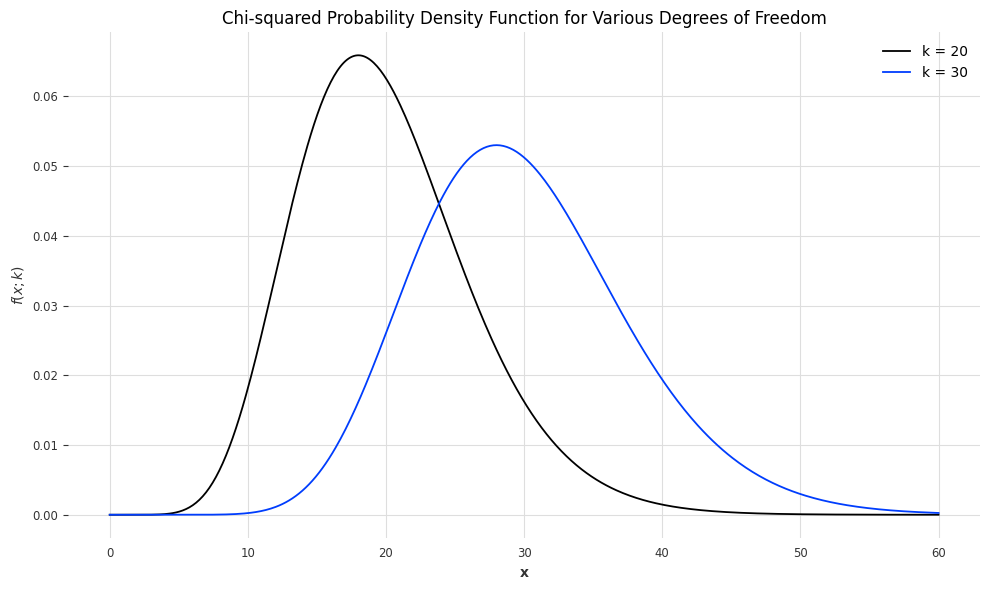

In [74]:
df_values = [20, 30]
x = np.linspace(0, 60, 500)

# Plot each PDF
plt.figure(figsize=(10, 6))
for df in df_values:
    pdf = chi2.pdf(x, df)
    plt.plot(x, pdf, label=f'k = {df}')

plt.title('Chi-squared Probability Density Function for Various Degrees of Freedom')
plt.xlabel('x')
plt.ylabel(r'$f(x; k)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
def ljung_box_test(series, max_lag, df_correction=0):
    n = len(series)
    acf_vals = acf(series, nlags=max_lag, fft=False)[1:]  # skip lag 0
    q_vals = []
    p_vals = []

    for h in range(1, max_lag + 1):
        Q_h = 0.0
        for k in range(1, h + 1):
            Q_h += (acf_vals[k - 1] ** 2) / (n - k)
        Q_h *= n * (n + 2)
        dof = h - df_correction
        p_value = 1 - chi2.cdf(Q_h, df=dof)
        
        q_vals.append(Q_h)
        p_vals.append(p_value)
    
    return np.array(q_vals), np.array(p_vals)


In [76]:
q_vals, p_vals = ljung_box_test(energy_consumption_data, max_lag=30, df_correction=0)
print(q_vals, p_vals)

[ 143.77214244  258.61454197  352.49683693  430.83280558  497.58894112
  553.14415597  598.15972953  629.79482191  650.72400049  662.56091792
  667.50259925  668.17206084  668.35874706  670.82060608  676.62766822
  688.56418901  708.24792211  733.02836855  764.89729759  800.3038753
  839.62014279  882.57285161  932.47444016  991.32418798 1057.39927117
 1129.82169044 1202.57025513 1270.66022355 1327.89866615 1376.37653225] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


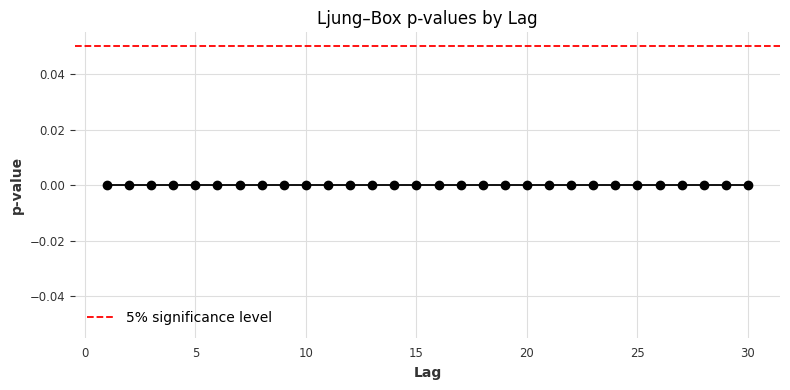

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(p_vals)+1), p_vals, marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='5% significance level')
plt.title('Ljung–Box p-values by Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


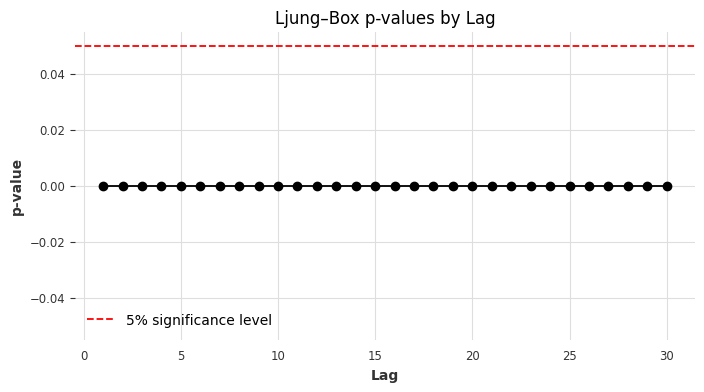

In [78]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(p_vals)+1), p_vals, marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='5% significance level')
plt.title('Ljung–Box p-values by Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.grid(True)
plt.legend()
plt.show()


In [79]:
max_lag = 30

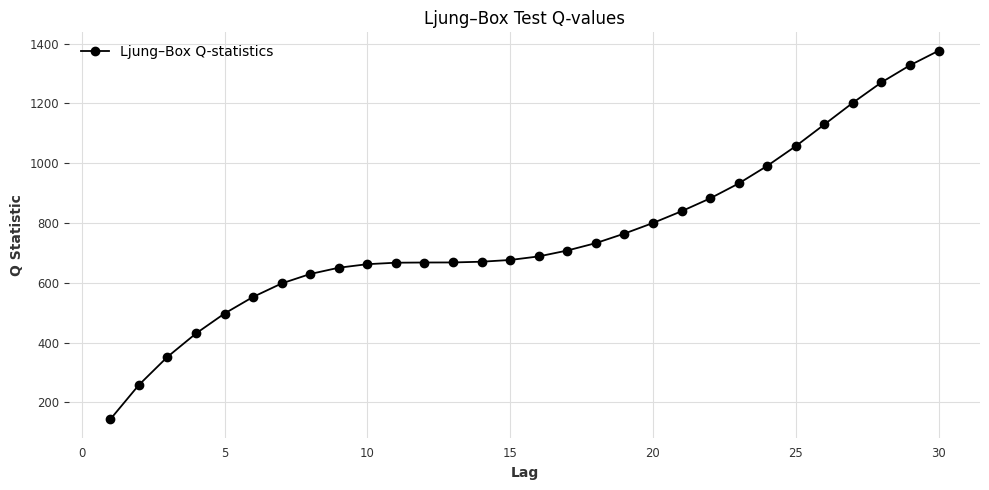

In [80]:
lags = np.arange(1, max_lag + 1)
crit_vals = chi2.ppf(1 - alpha, df=lags)

plt.figure(figsize=(10, 5))
plt.plot(lags, q_vals, marker='o', label='Ljung–Box Q-statistics')

plt.title('Ljung–Box Test Q-values')
plt.xlabel('Lag')
plt.ylabel('Q Statistic')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


from darts.models import ARIMA
series = TimeSeries.from_values(energy_consumption_data)
# Fit model
model = ARIMA(5, 1, 2)
model.fit(series)

# Get residuals
residuals = model.residuals(series)
# Flatten and test
q_vals, p_vals = ljung_box_test(residuals.values().flatten() , max_lag=30)
lags = np.arange(1, max_lag + 1)
crit_vals = chi2.ppf(1 - alpha, df=lags)

plt.figure(figsize=(10, 5))
plt.plot(lags, q_vals, marker='o', label='Ljung–Box Q-statistics')

plt.title('Ljung–Box Test Q-values (Residuals of ARIMA 5,2,1)')
plt.xlabel('Lag')
plt.ylabel('Q Statistic')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

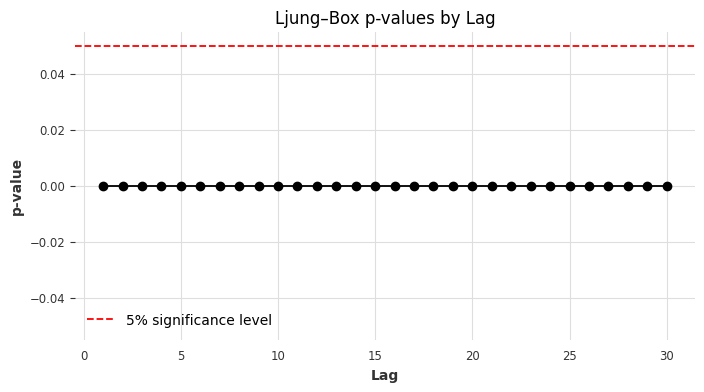

In [81]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(p_vals)+1), p_vals, marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='5% significance level')
plt.title('Ljung–Box p-values by Lag')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.grid(True)
plt.legend()
plt.show()


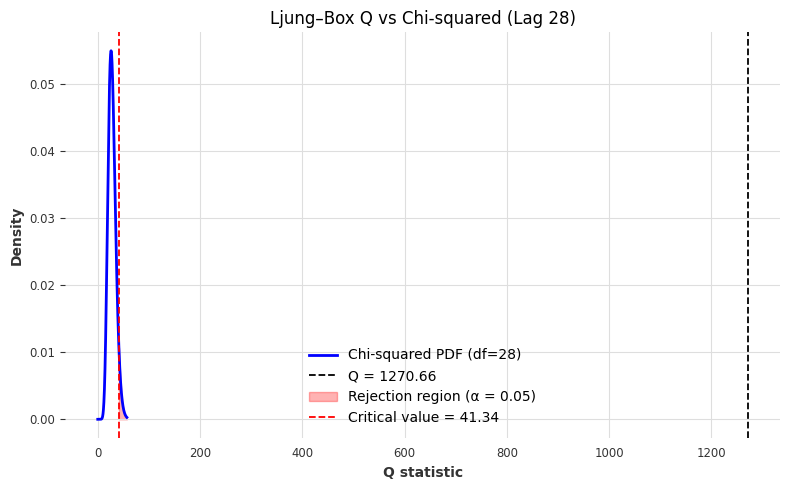

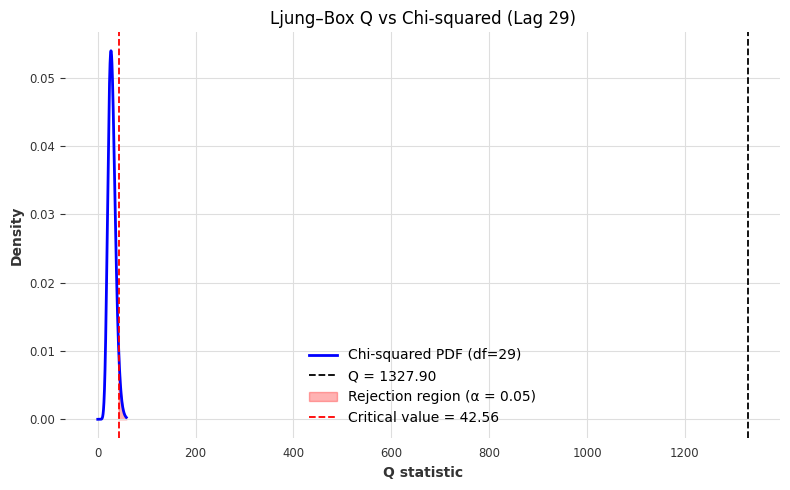

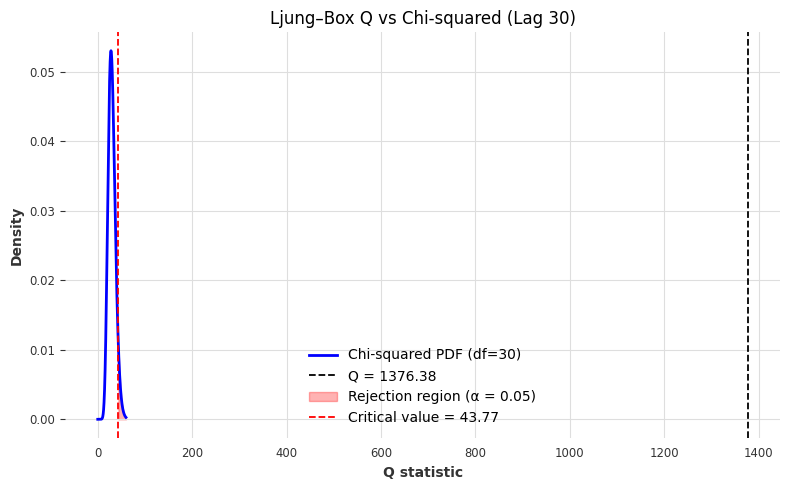

In [82]:
alpha = 0.05

# Loop over each lag and plot
for i in range(len(q_vals)*29//32,len(q_vals)):
    lag = i + 1                  # lag number = degrees of freedom
    Q = q_vals[i]                # Q-statistic for this lag
    df = lag
    crit_val = chi2.ppf(1 - alpha, df)

    # Generate chi2 PDF
    x = np.linspace(0, chi2.ppf(0.999, df), 500)
    pdf = chi2.pdf(x, df)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf, 'b-', lw=2, label=f'Chi-squared PDF (df={df})')

    # Vertical line for observed Q-statistic
    plt.axvline(Q, color='black', linestyle='--', label=f'Q = {Q:.2f}')

    # Rejection region
    x_fill = np.linspace(crit_val, chi2.ppf(0.999, df), 200)
    plt.fill_between(x_fill, chi2.pdf(x_fill, df), color='red', alpha=0.3, label='Rejection region (α = 0.05)')

    # Critical value line
    plt.axvline(crit_val, color='red', linestyle='--', label=f'Critical value = {crit_val:.2f}')

    plt.title(f'Ljung–Box Q vs Chi-squared (Lag {lag})')
    plt.xlabel('Q statistic')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Checking normality using QQ Plots

In [83]:
from scipy.stats import norm


In [84]:

def qq_plot(data, title='Q-Q Plot vs Normal', confidence=0.95):
    data = np.sort(data)
    n = len(data)

    # Theoretical quantiles (standard normal)
    probs = np.arange(1, n + 1) / (n + 1)
    theoretical_quantiles = norm.ppf(probs)

    # Confidence bands (optional)
    z = norm.ppf(1 - (1 - confidence) / 2)
    se = (1 / norm.pdf(theoretical_quantiles)) * np.sqrt(probs * (1 - probs) / (n + 1))
    upper = theoretical_quantiles + z * se
    lower = theoretical_quantiles - z * se

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(theoretical_quantiles, data, 'o', label='Sample quantiles')
    plt.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label='Ideal line')

    # Confidence bands
    plt.fill_between(theoretical_quantiles, lower, upper, color='gray', alpha=0.2,
                     label=f'{int(confidence * 100)}% confidence band')

    plt.xlabel('Theoretical Quantiles (Normal)')
    plt.ylabel('Sample Quantiles')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()



In [85]:
data = (df_2_difference - np.mean(df_2_difference)) / np.std(df_2_difference)

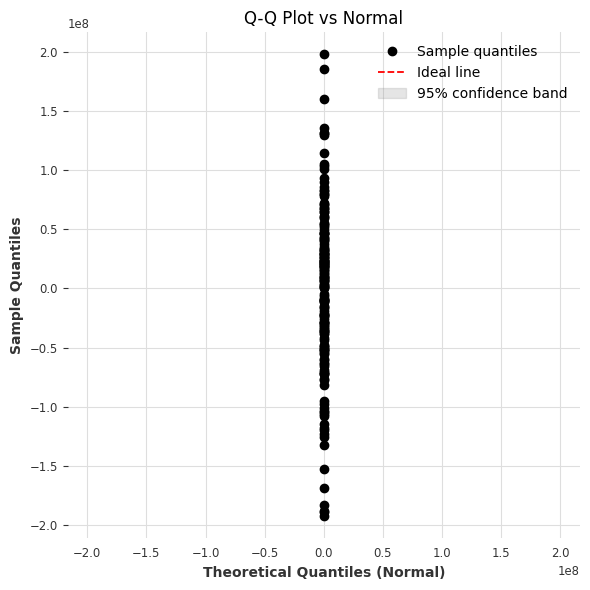

In [86]:
qq_plot(df_2_difference)

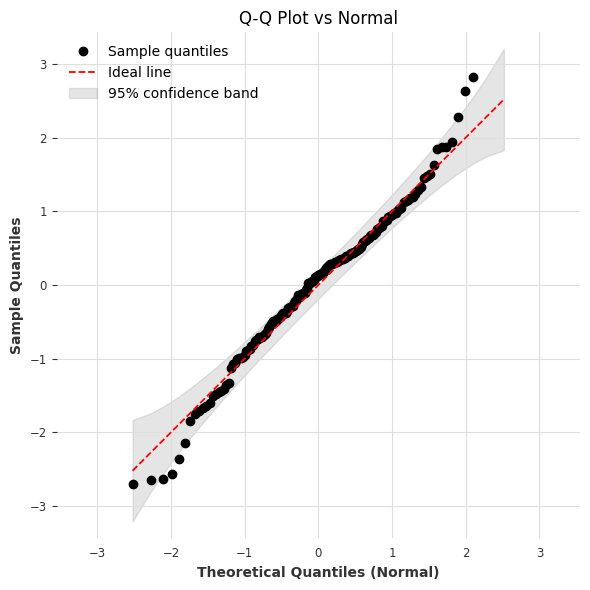

In [87]:
qq_plot(data)

# Periodogram 

In [88]:
def compute_linear_periodogram(y):
    y = np.asarray(y)
    n = len(y)
    m = (n - 1) // 2 if n % 2 else n // 2
    freqs = np.arange(1, m + 1) / n
    I_vals = []

    for omega in freqs:
        cos_part = np.sum(y * np.cos(2 * np.pi * omega * np.arange(1, n + 1)))
        sin_part = np.sum(y * np.sin(2 * np.pi * omega * np.arange(1, n + 1)))
        I = (1 / n) * (cos_part**2 + sin_part**2)
        I_vals.append(I)

    return freqs, np.array(I_vals)


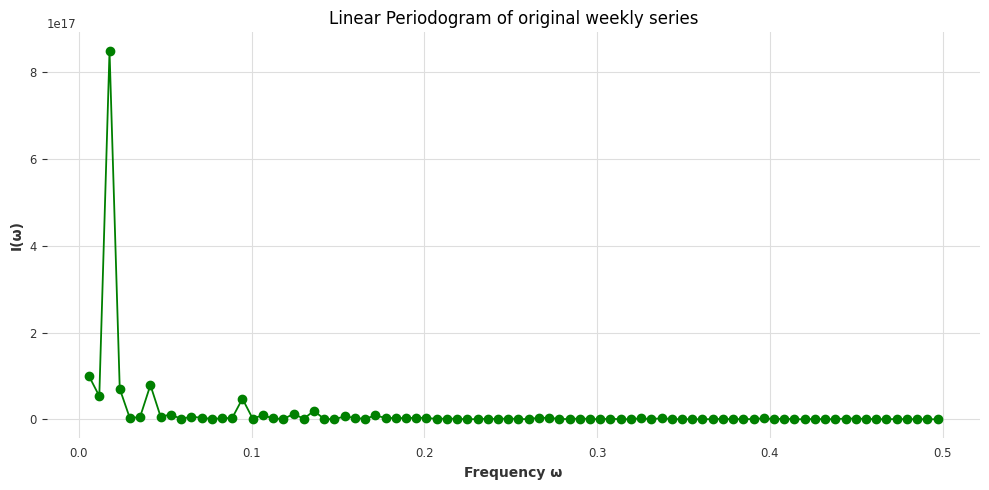

In [89]:
freqs, I_vals = compute_linear_periodogram(energy_consumption_data)
plt.figure(figsize=(10, 5))
plt.plot(freqs, I_vals, marker='o', color = 'g')
plt.title("Linear Periodogram of original weekly series")
plt.xlabel('Frequency ω')
plt.ylabel("I(ω)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
significant_frequencies = [(w, I) for w, I in zip(freqs, I_vals) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

NameError: name 'threshold' is not defined

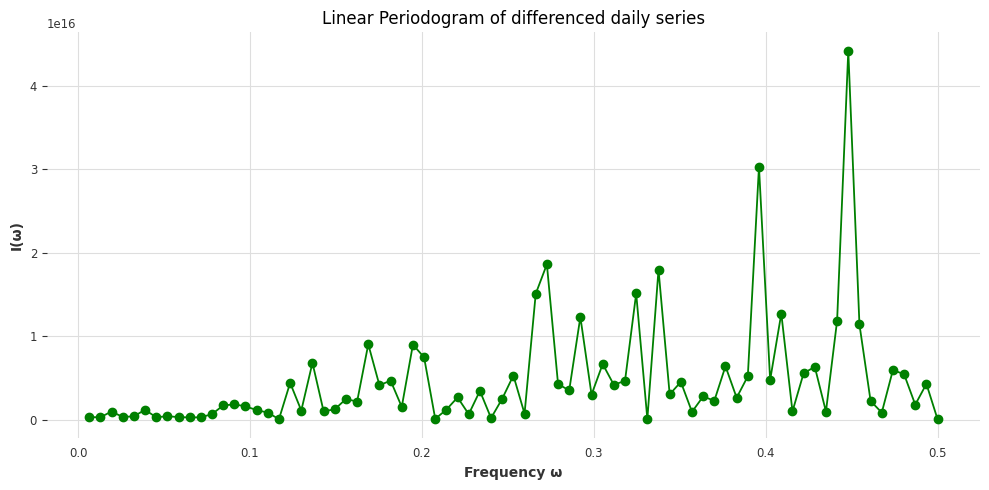

In [ ]:
freqs, I_vals = compute_linear_periodogram(df_2_difference.dropna())
plt.figure(figsize=(10, 5))
plt.plot(freqs, I_vals, marker='o', color = 'g')
plt.title("Linear Periodogram of differenced daily series")
plt.xlabel('Frequency ω')
plt.ylabel("I(ω)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
threshold=2*1e16

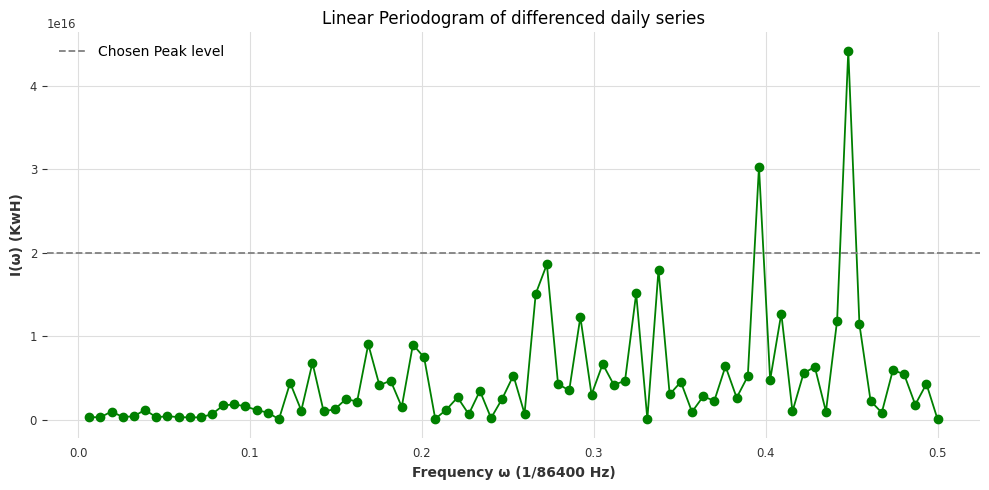

In [ ]:
freqs, I_vals = compute_linear_periodogram(df_2_difference.dropna())
plt.figure(figsize=(10, 5))
plt.plot(freqs, I_vals, marker='o', color = 'g')
plt.title("Linear Periodogram of differenced daily series")
plt.xlabel('Frequency ω (1/86400 Hz)')
plt.axhline(threshold, color='grey', linestyle='--', label='Chosen Peak level')
plt.ylabel("I(ω) (KwH)")
plt.grid(True)
plt.tight_layout()
plt.legend()

In [ ]:
significant_frequencies = [(w, I) for w, I in zip(freqs, I_vals) if I > threshold]
for freq, power in significant_frequencies:
    print(f"Frequency: {freq:.5f}, Power: {power:.2e}, Period ≈ {1/freq:.2f} weeks")

Frequency: 0.39610, Power: 3.03e+16, Period ≈ 2.52 weeks
Frequency: 0.44805, Power: 4.42e+16, Period ≈ 2.23 weeks


Plotting one of the Fourrier Series

In [ ]:
from matplotlib.cm import get_cmap


Plotting sine waves in separate subplots with different colors.

In [ ]:
def plot_significant_waves(significant_freqs, duration=30, sampling_rate=100):
    t = np.linspace(0, duration, duration * sampling_rate)
    n = len(significant_freqs)
    cmap = get_cmap('tab10')

    max_amplitude = max(power for _, power in significant_freqs)

    fig, axs = plt.subplots(n, 1, figsize=(11, 1.5 * n), sharex=True)
    if n == 1:
        axs = [axs]

    for i, (freq, power) in enumerate(significant_freqs):
        amplitude = power
        y = amplitude * np.sin(2 * np.pi * freq * t)
        color = cmap(i % cmap.N)
        axs[i].plot(t, y, color=color)
        axs[i].set_ylim(-max_amplitude * 1.1, max_amplitude * 1.1)
        axs[i].set_title(f'ω = {freq:.3f}, T ≈ {1/freq:.2f} days, Power = {power:.2e}', fontsize=10)
        axs[i].set_ylabel('Amplitude')
        axs[i].grid(True)

    axs[-1].set_xlabel('Time (days)')
    plt.tight_layout()
    fig.suptitle("Decomposed High Signals of Differenced Daily Series (threshold= 2.7*1e16) ", fontsize=14, y=1.02)
    plt.show()


In [ ]:
threshold= 2.7*1e16

/var/folders/t4/tvh60p3s6t1g30sq60618qpw0000gn/T/ipykernel_22064/3103065588.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



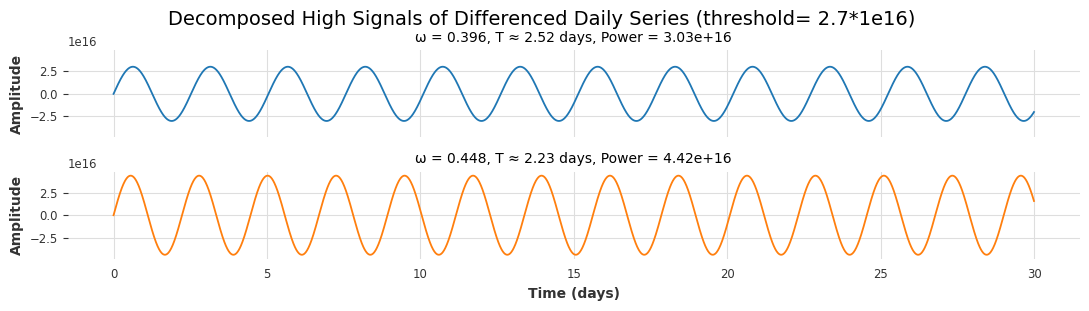

In [ ]:
significant_frequencies = [(w, I) for w, I in zip(freqs, I_vals) if I > threshold]
plot_significant_waves(significant_frequencies, duration=30, sampling_rate=100)

In [ ]:
def reconstruct_signal_from_spectrum_on_index(significant_freqs, time_index):
    """
    Reconstructs a signal using the real time index of the DataFrame.

    Parameters:
    - significant_freqs: list of (frequency, power) tuples
    - time_index: pd.Index or np.array of time points (can be dates or numbers)

    Returns:
    - time_index: same as input
    - reconstructed_signal: sum of sine waves
    """
    t = np.arange(len(time_index))  # Numerical index for frequency use
    reconstructed_signal = np.zeros_like(t, dtype=float)

    for freq, power in significant_freqs:
        y = power * np.sin(2 * np.pi * freq * t)
        reconstructed_signal += y

    return time_index, reconstructed_signal

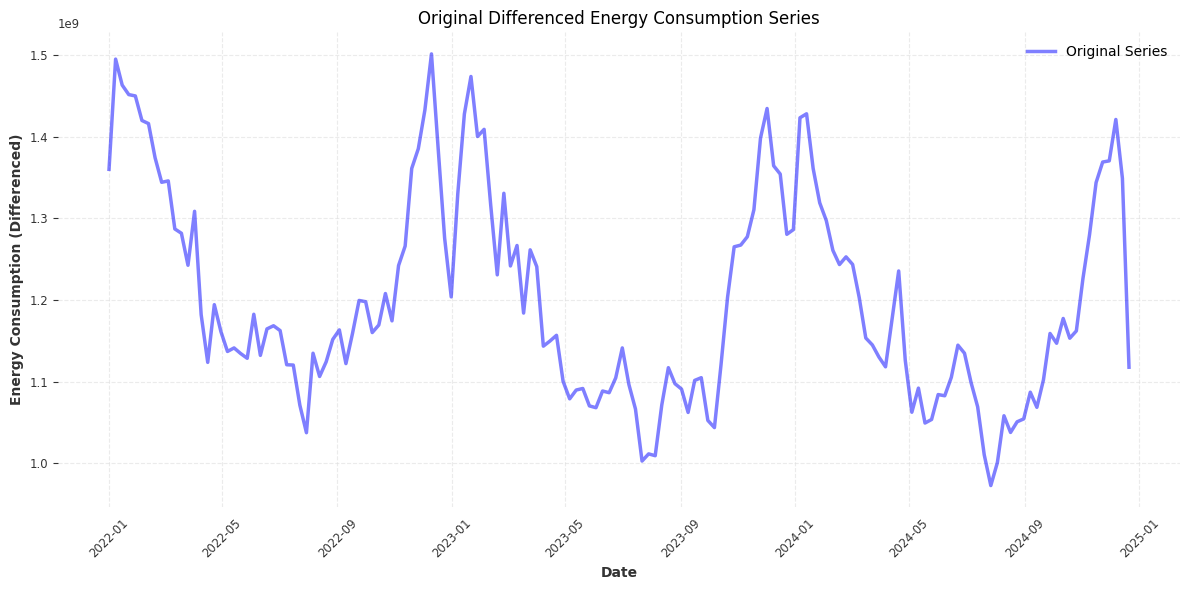

In [ ]:
t_index, recon = reconstruct_signal_from_spectrum_on_index(significant_frequencies, time_index)
plt.figure(figsize=(12, 6))
plt.plot(time_index[:len(energy_consumption_data)], energy_consumption_data, label='Original Series', linewidth=2.5, color = 'blue', alpha=0.5)
plt.title("Original Differenced Energy Consumption Series")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (Differenced)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


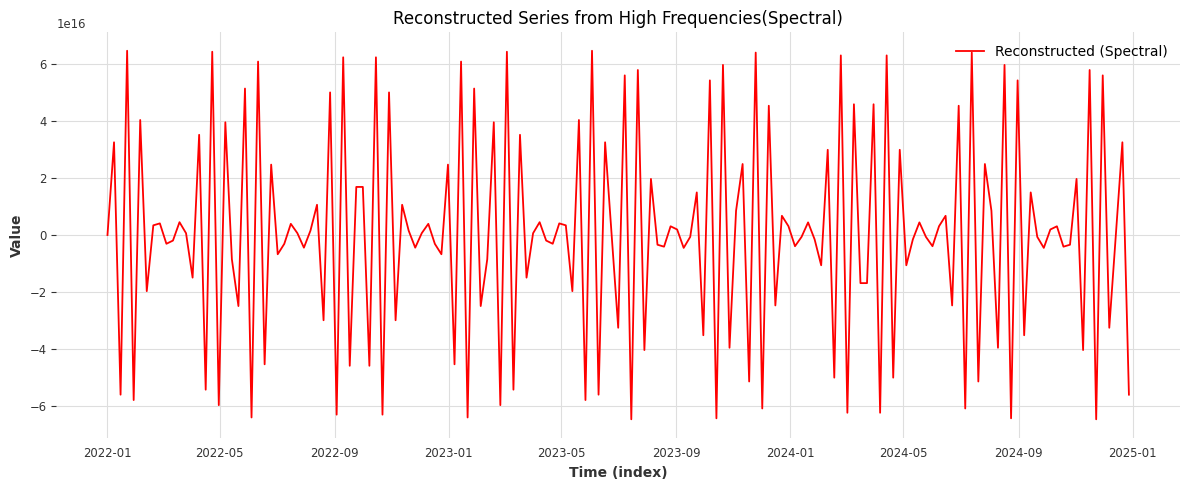

In [ ]:

t_index, recon = reconstruct_signal_from_spectrum_on_index(significant_frequencies, time_index)

plt.figure(figsize=(12, 5))
plt.plot(t_index, recon, label='Reconstructed (Spectral)', color = 'r')
plt.title("Reconstructed Series from High Frequencies(Spectral)")
plt.xlabel("Time (index)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
def plot_cumulative_periodogram(freqs, I_vals, show_plot=True):
    """
    Computes and (optionally) plots the cumulative periodogram with KS reference line.

    Parameters:
    - freqs: array-like, frequencies ω_j
    - I_vals: array-like, periodogram values I(ω_j)
    - show_plot: bool, whether to display the plot

    Returns:
    - freqs: np.array of frequencies (same as input)
    - C: np.array of cumulative values C_r
    """
    freqs = np.array(freqs)
    I_vals = np.array(I_vals)

    total_power = np.sum(I_vals)
    cumulative_power = np.cumsum(I_vals)
    C = cumulative_power / total_power

    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.step(freqs, C, where='post', label="Cumulative Periodogram", color='blue', lw=2)
        plt.plot([freqs[0], freqs[-1]], [0, 1], 'r--', label="KS Line: $y = x$")
        plt.xlabel("Frequency ω (1/day)")
        plt.ylabel("Cumulative Proportion of Power")
        plt.title("Cumulative Periodogram vs flat spectrum Line")
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return freqs, C



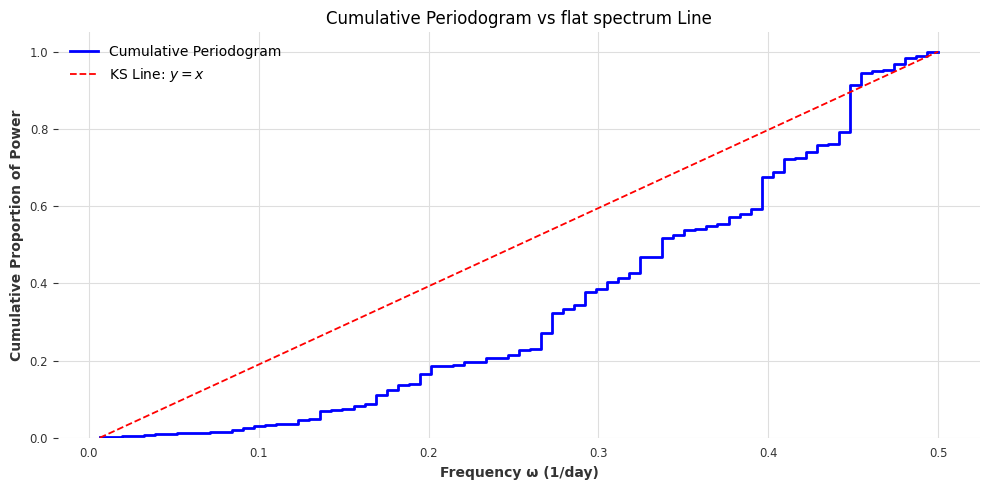

In [ ]:
freqs_sorted, C_vals = plot_cumulative_periodogram(freqs, I_vals)


# Smoothing

# Moving averages

7-day MA

In [ ]:
def sliced_mean_calculator_with_overlap(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices

In [ ]:
mean_window_size = 7

In [ ]:
means, time_indices = sliced_mean_calculator_with_overlap(energy_consumption_data,time_index, mean_window_size)

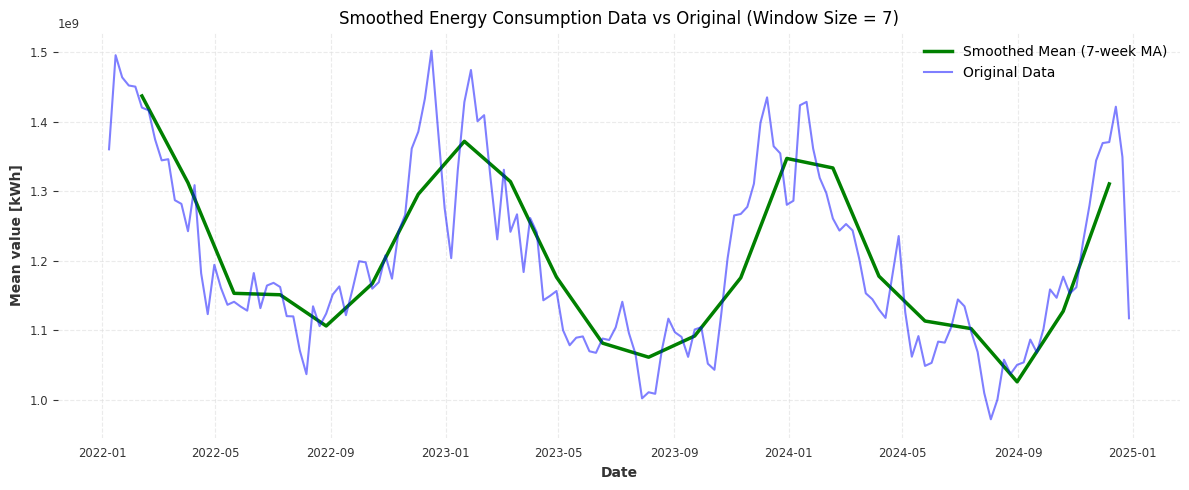

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', linewidth=2.5, label='Smoothed Mean (7-week MA)')
plt.plot(time_index[1:], energy_consumption_data, color='blue', alpha=0.5, linewidth=1.5, label='Original Data')
plt.xlabel('Date')
plt.ylabel('Mean value [kWh]')
plt.title(f'Smoothed Energy Consumption Data vs Original (Window Size = {mean_window_size})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# 3 Point Moving Average

In [ ]:
def three_point_moving_average(data, time_index):
    means = []
    time_indices = []
    
    for i in range(1, len(data) - 1):  # skip first and last point
        avg = (data[i - 1] + data[i] + data[i + 1]) / 3
        means.append(avg)
        time_indices.append(time_index[i]) 
    
    return means, time_indices


In [ ]:
means, time_indices = three_point_moving_average(energy_consumption_data,time_index)

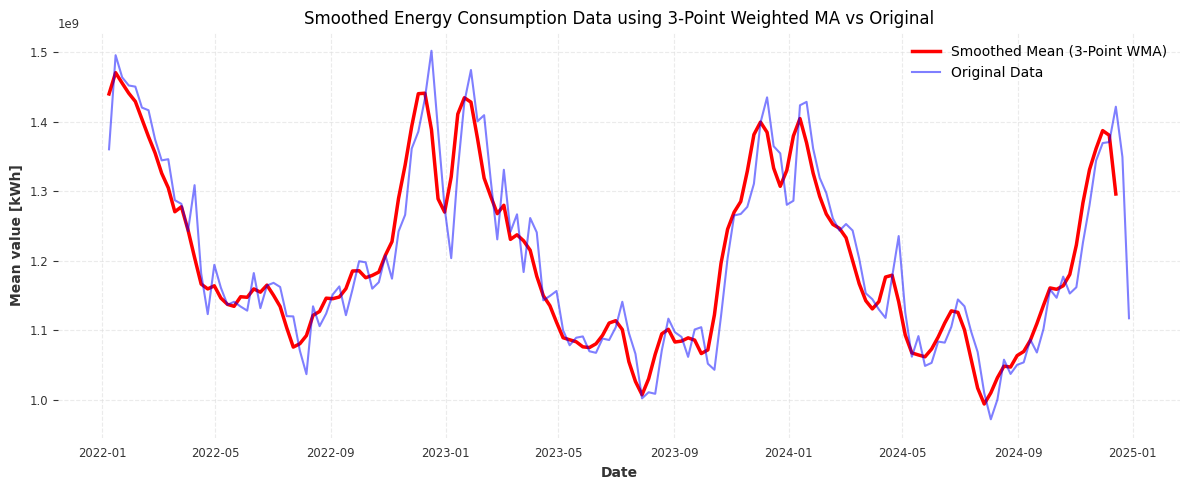

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='red', linewidth=2.5, label='Smoothed Mean (3-Point WMA)')
plt.plot(time_index[1:], energy_consumption_data, color='blue', alpha=0.5, linewidth=1.5, label='Original Data')
plt.xlabel('Date')
plt.ylabel('Mean value [kWh]')
plt.title(f'Smoothed Energy Consumption Data using 3-Point Weighted MA vs Original')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Determining Weights

In [ ]:
from darts.models.filtering.moving_average_filter import MovingAverageFilter

In [ ]:
# Prepare the TimeSeries from time_index[1:] and energy_consumption_data
series = TimeSeries.from_times_and_values(time_index[1:], energy_consumption_data)

# 1. Simple smoother: 3-point moving average applied twice
ma_filter = MovingAverageFilter(window=3, centered=True)
simple_smooth_1 = ma_filter.filter(series)
simple_smooth_2 = ma_filter.filter(simple_smooth_1)

# 2. Higher-order smoother (custom weights with NumPy)
weights = np.array([1/24] + [2/24]*11 + [1/24])
weights /= weights.sum()
higher_order_values = np.convolve(series.values().flatten(), weights, mode='same')
higher_order_smooth = TimeSeries.from_times_and_values(series.time_index, higher_order_values)

# 3. Smaller-order smoother: 3-point moving average (again)
small_order_smooth = ma_filter.filter(series)


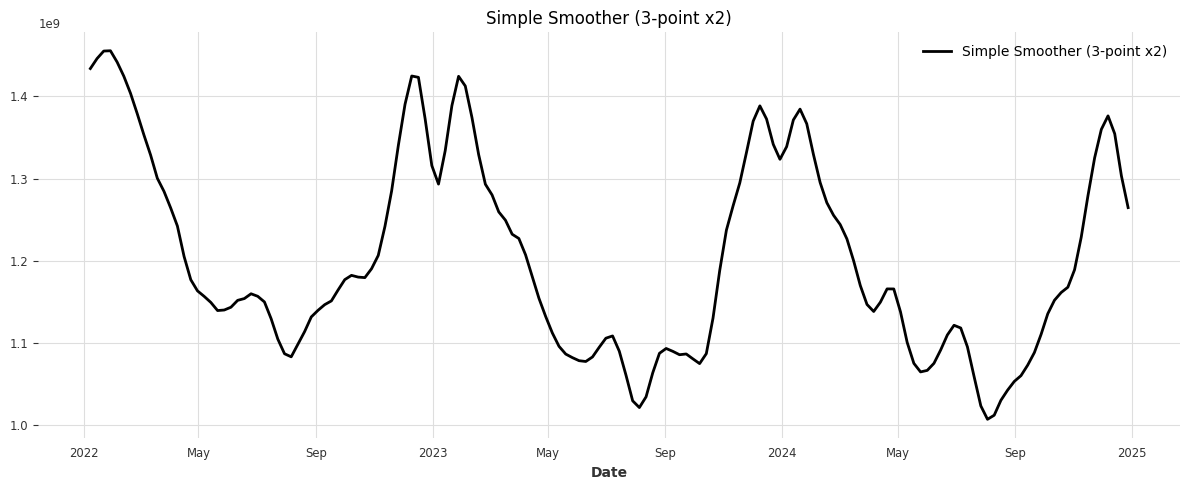

In [ ]:
# Plot all
plt.figure(figsize=(12, 5))
simple_smooth_2.plot(label="Simple Smoother (3-point x2)")
plt.title("Simple Smoother (3-point x2)")
plt.grid(True)
plt.tight_layout()
plt.xlabel('Date')
plt.legend()
plt.show()

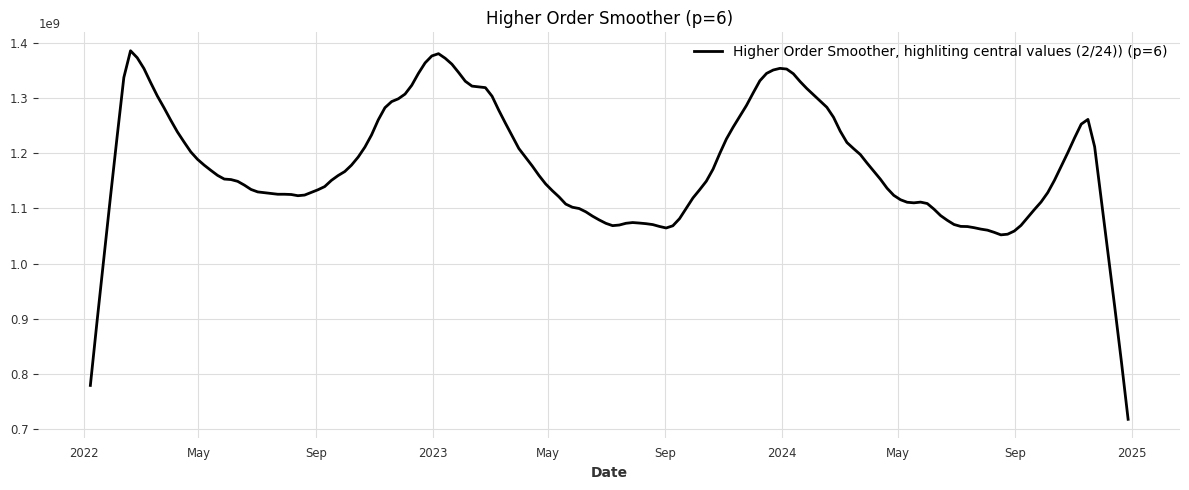

In [ ]:
plt.figure(figsize=(12, 5))
higher_order_smooth.plot(label="Higher Order Smoother, highliting central values (2/24)) (p=6)")
plt.title("Higher Order Smoother (p=6)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.show()

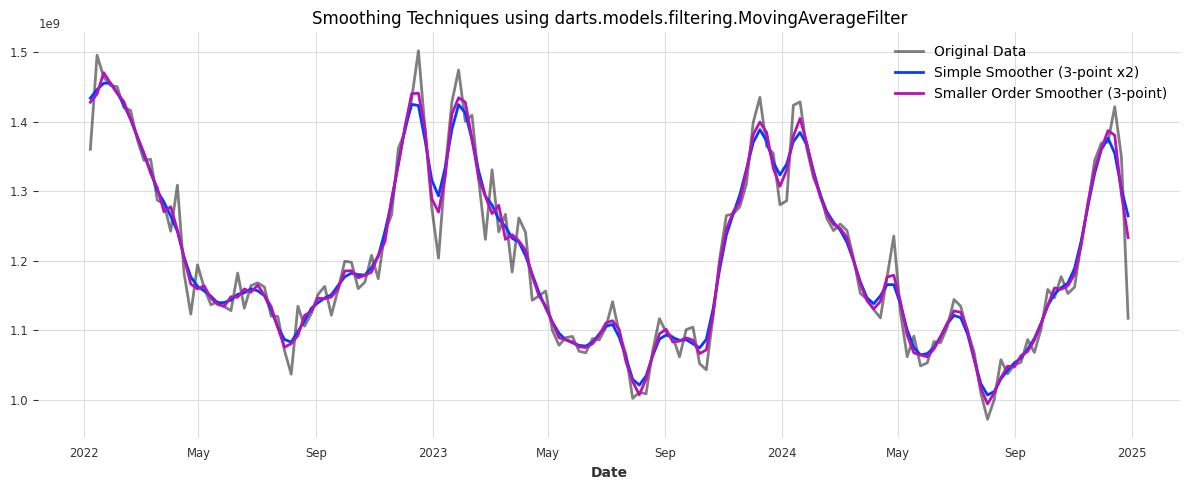

In [ ]:
plt.figure(figsize=(12, 5))
series.plot(label="Original Data", alpha=0.5)
simple_smooth_2.plot(label="Simple Smoother (3-point x2)")
small_order_smooth.plot(label="Smaller Order Smoother (3-point)")
plt.title("Smoothing Techniques using darts.models.filtering.MovingAverageFilter")
plt.grid(True)
plt.tight_layout()
plt.xlabel('Date')
plt.legend()
plt.show()

Cumulative frequencies compared to time series

# Local Polynomial Regression

In [ ]:
frac = 0.1

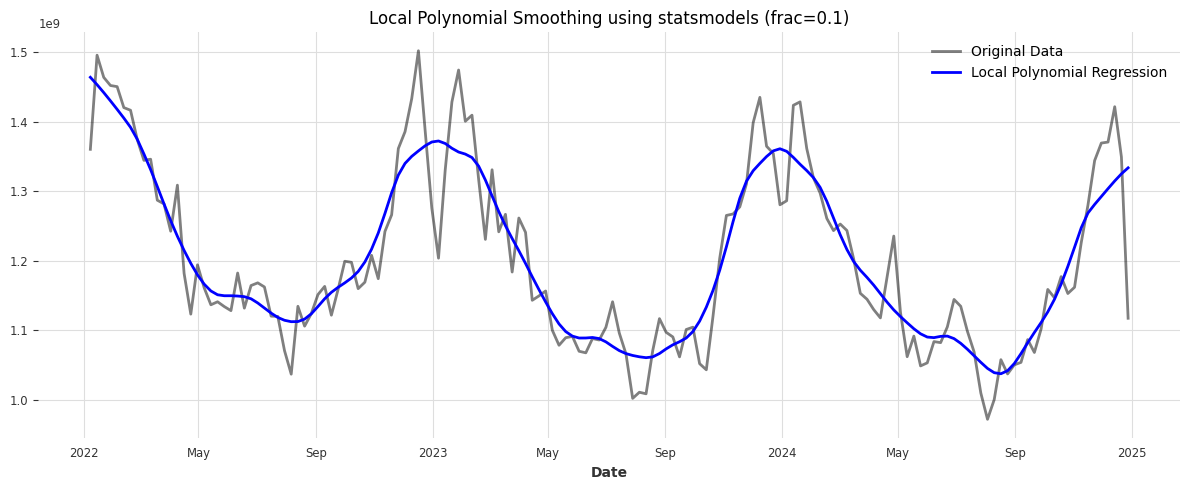

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Wrap your data
series = TimeSeries.from_times_and_values(time_index[1:], energy_consumption_data)

# Extract values for LOWESS
x = np.arange(len(series))  # numeric time axis
y = series.values().flatten()

# Apply LOWESS smoothing
smoothed = lowess(endog=y, exog=x, frac=frac, it=0, return_sorted=False)

# Convert back to a Darts TimeSeries
loess_series = TimeSeries.from_times_and_values(series.time_index, smoothed)

# Plot
plt.figure(figsize=(12, 5))
series.plot(label='Original Data', alpha=0.5)
loess_series.plot(label='Local Polynomial Regression',color='blue')
plt.title("Local Polynomial Smoothing using statsmodels (frac=0.1)")
plt.grid(True)
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
frac = 0.25

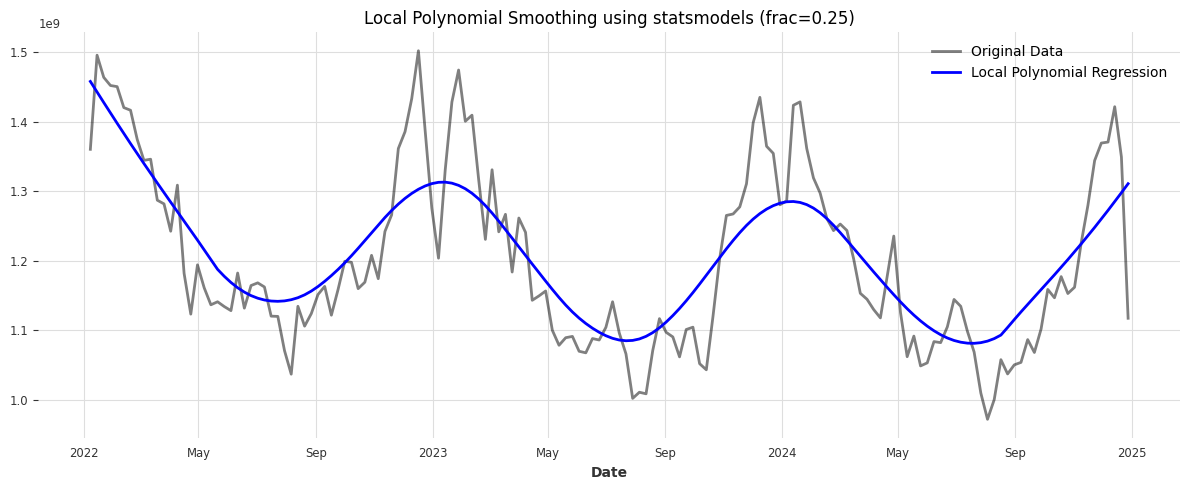

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Wrap your data
series = TimeSeries.from_times_and_values(time_index[1:], energy_consumption_data)

# Extract values for LOWESS
x = np.arange(len(series))  # numeric time axis
y = series.values().flatten()

# Apply LOWESS smoothing
smoothed = lowess(endog=y, exog=x, frac=frac, it=0, return_sorted=False)

# Convert back to a Darts TimeSeries
loess_series = TimeSeries.from_times_and_values(series.time_index, smoothed)

# Plot
plt.figure(figsize=(12, 5))
series.plot(label='Original Data', alpha=0.5)
loess_series.plot(label='Local Polynomial Regression',color='blue')
plt.title("Local Polynomial Smoothing using statsmodels (frac=0.25)")
plt.grid(True)
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


**III. 1.a. Formal check**

Akaike Information Criterion:

AIC=2k−2ln(L)
where:
k = number of parameters in the model
L = maximum value of the likelihood function for the model

Bayesian Information Criterion: heavier penalty for models with more parameters

In [ ]:
from darts.utils.statistics import (
    remove_trend,
    stationarity_test_adf,
    stationarity_test_kpss,
    plot_acf,
    plot_pacf,
    plot_residuals_analysis,
    check_seasonality,
    extract_trend_and_seasonality,
    remove_from_series
)
from darts.utils.utils      import ModelMode, SeasonalityMode

2. seasonality check


expliquez comment seasonality marche, comment trending marche, pourquoi on n'a pas utilité IGD, 

In [ ]:
time_series = TimeSeries.from_values(energy_consumption_data)

In [ ]:
has_season, m = check_seasonality(time_series, m=None, max_lag=60, alpha=0.05)
print(f"Has seasonality? {has_season}, period = {m} days")

Has seasonality? True, period = 52 days


Extracting Trend and Seasonality

I'm going to use a DARTS function

method (str) – The method to be used to decompose the series. - “naive” : Seasonal decomposition using moving averages [1]. - “STL” : Season-Trend decomposition using LOESS [2]. Only compatible with ADDITIVE model type. - “MSTL” : Season-Trend decomposition using LOESS with multiple seasonalities [3]. Only compatible with ADDITIVE model type.


comprendre les deux

2. (a) “naive” moving-average decomposition (additive)

In [ ]:
trend_naive, seas_naive = extract_trend_and_seasonality(
    time_series,
    freq=4,
    model= ModelMode.ADDITIVE,
    method='naive'
)

<Figure size 1200x800 with 0 Axes>

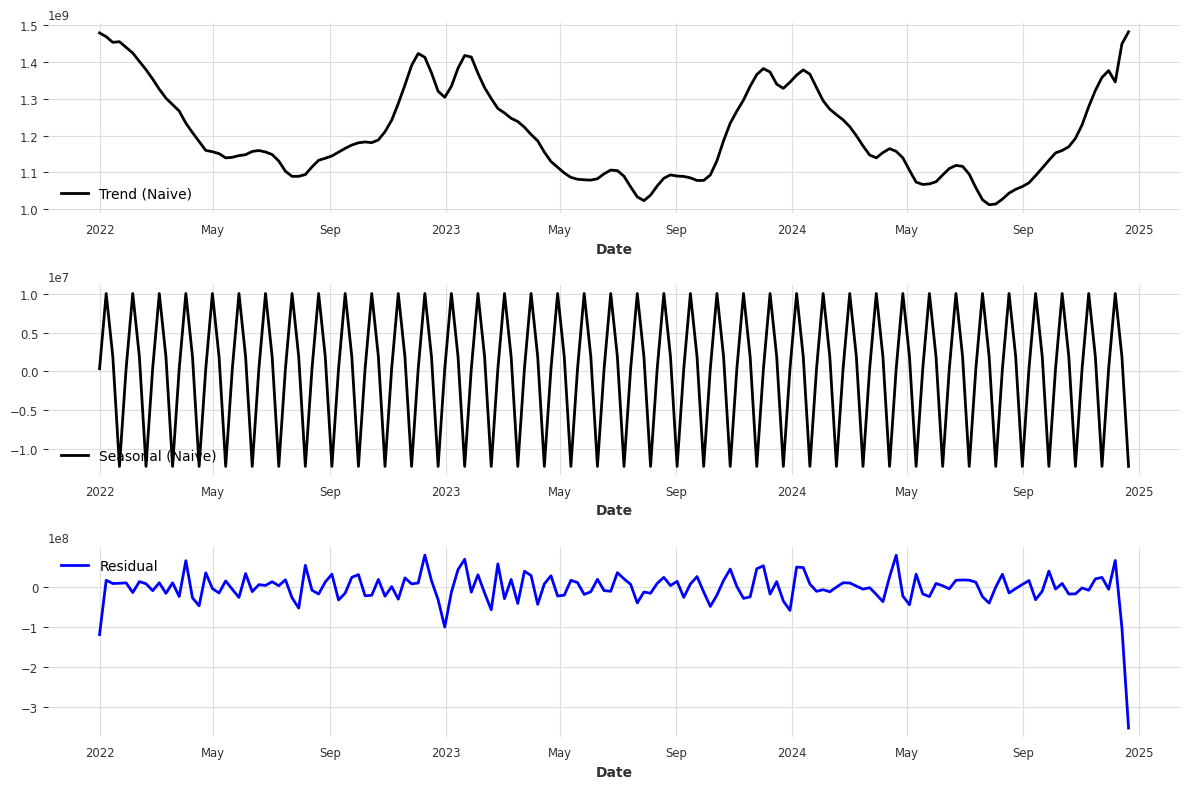

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 8))
trend_naive = TimeSeries.from_times_and_values(time_index[:len(trend_naive)], trend_naive.values())
seas_naive = TimeSeries.from_times_and_values(time_index[:len(trend_naive)], seas_naive.values())
residual = TimeSeries.from_times_and_values(time_index[:len(trend_naive)] ,(time_series - trend_naive - seas_naive).values())

# Plot
plt.figure(figsize=(12, 8))
ax = plt.subplot(311); trend_naive.plot(ax=ax, label='Trend (Naive)'); ax.legend()
plt.xlabel("Date")
ax = plt.subplot(312); seas_naive.plot(ax=ax, label='Seasonal (Naive)'); ax.legend()
plt.xlabel("Date")
ax = plt.subplot(313); residual.plot(ax=ax, label='Residual',color ="b"); ax.legend()
plt.xlabel("Date")
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

2. (b) STL decomposition

In [ ]:
trend, seasonal = extract_trend_and_seasonality(
    time_series,
    freq=4,
    model=ModelMode.ADDITIVE,
    method='STL',
    robust=True 
)

Plotting STL results

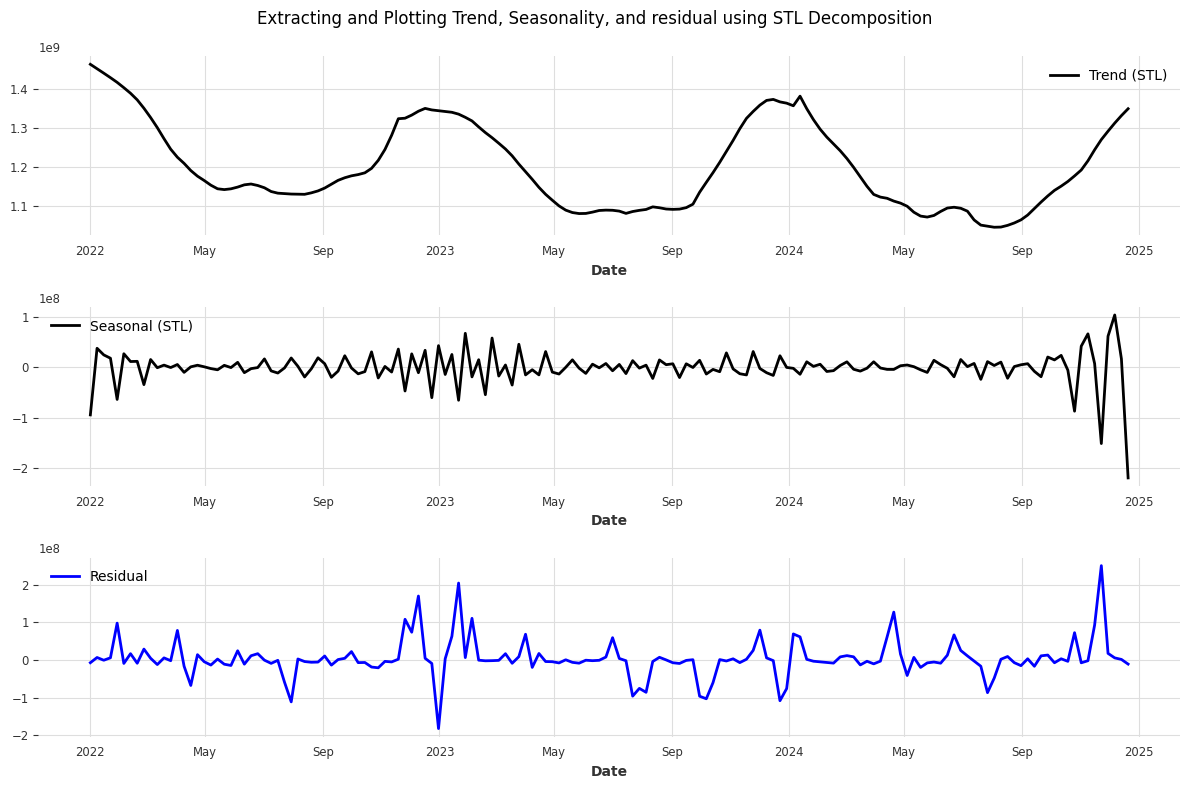

In [ ]:
trend = TimeSeries.from_times_and_values(time_index[:len(trend)], trend.values())
seasonal = TimeSeries.from_times_and_values(time_index[:len(seasonal)], seasonal.values())
residual = TimeSeries.from_times_and_values(time_index[:len(trend)] ,(time_series - trend - seasonal).values())


plt.figure(figsize=(12, 8))
plt.suptitle("Extracting and Plotting Trend, Seasonality, and residual using STL Decomposition")
ax = plt.subplot(311); trend.plot(label='Trend (STL)', ax=ax)
plt.xlabel("Date")
ax = plt.subplot(312); seasonal.plot(label='Seasonal (STL)', ax=ax)
plt.xlabel("Date")
ax = plt.subplot(313); residual.plot(label='Residual',color='blue', ax=ax)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [ ]:
trend, seasonal = extract_trend_and_seasonality(
    time_series,
    freq=4,
    model=ModelMode.ADDITIVE,
    method='MSTL',
)

Plotting MSTL

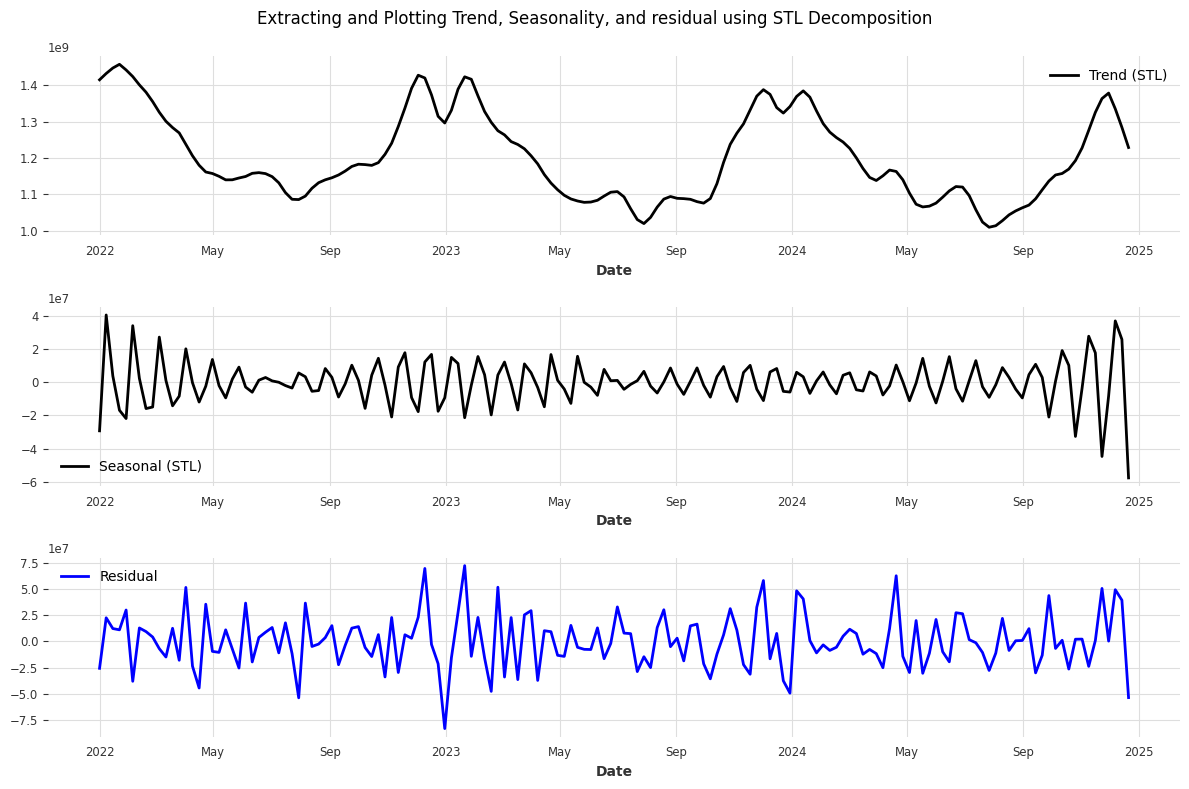

In [ ]:
trend = TimeSeries.from_times_and_values(time_index[:len(trend)], trend.values())
seasonal = TimeSeries.from_times_and_values(time_index[:len(seasonal)], seasonal.values())
residual = TimeSeries.from_times_and_values(time_index[:len(trend)] ,(time_series - trend - seasonal).values())


plt.figure(figsize=(12, 8))
plt.suptitle("Extracting and Plotting Trend, Seasonality, and residual using STL Decomposition")
ax = plt.subplot(311); trend.plot(label='Trend (STL)', ax=ax)
plt.xlabel("Date")
ax = plt.subplot(312); seasonal.plot(label='Seasonal (STL)', ax=ax)
plt.xlabel("Date")
ax = plt.subplot(313); residual.plot(label='Residual',color='blue', ax=ax)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

Check si il y a plusieurs fréquences, lequels, c'est quoi leurs amplitudes, check residual stat

Removing seasonality and trend

Removing seasonality

In [ ]:
ts_deseason = remove_from_series(time_series, seasonal, SeasonalityMode.ADDITIVE)


Removing trend

In [ ]:
ts_detrended = remove_from_series(ts_deseason, trend, ModelMode.ADDITIVE)

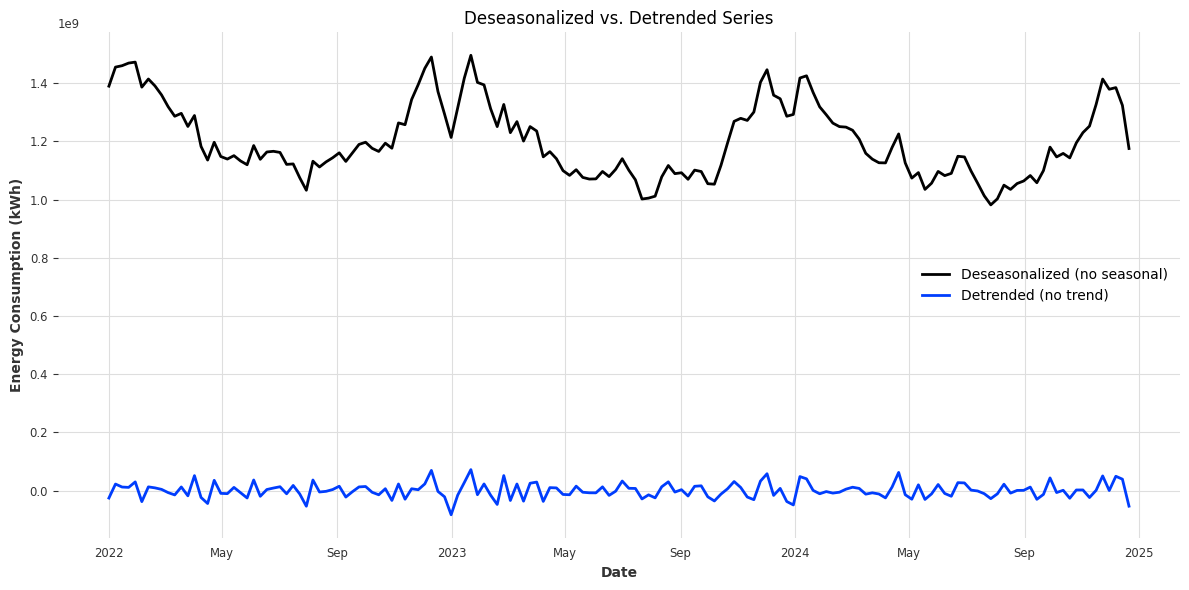

In [ ]:
ts_deseason = TimeSeries.from_times_and_values(time_index[:len(ts_deseason)], ts_deseason.values())
ts_detrended = TimeSeries.from_times_and_values(time_index[:len(ts_detrended)], ts_detrended.values())

plt.figure(figsize=(12, 6))
ax = plt.gca()
ts_deseason.plot(label='Deseasonalized (no seasonal)', ax=ax)
ts_detrended.plot(label='Detrended (no trend)', ax=ax)

plt.title('Deseasonalized vs. Detrended Series')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


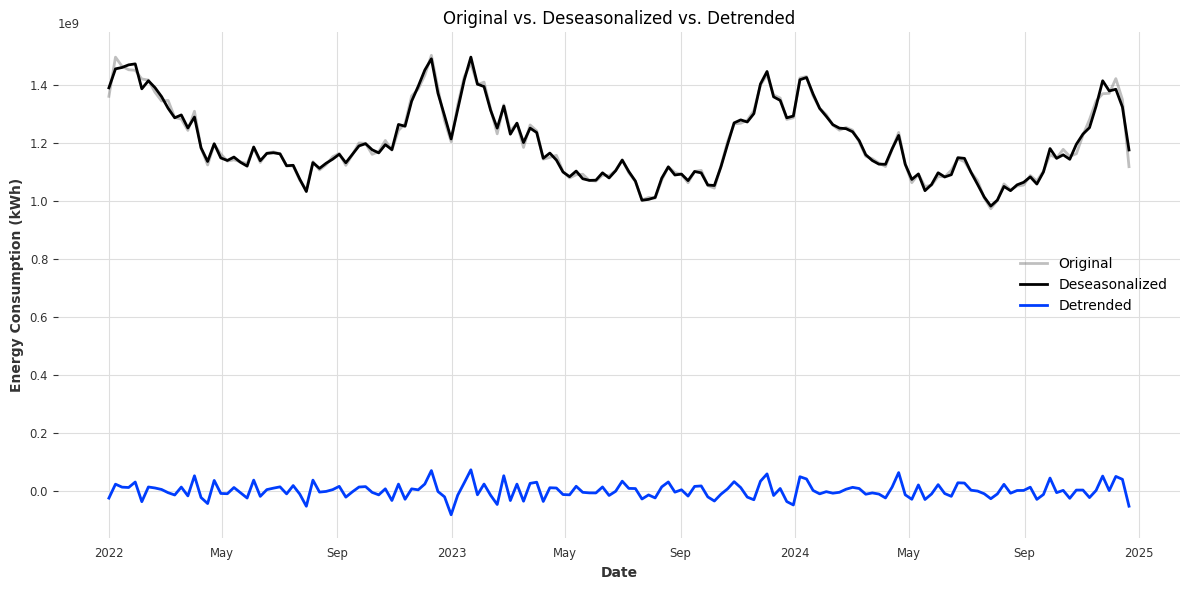

In [ ]:
ts_deseason = TimeSeries.from_times_and_values(time_index[:len(ts_deseason)], ts_deseason.values())
ts_detrended = TimeSeries.from_times_and_values(time_index[:len(ts_detrended)], ts_detrended.values())
time_series = TimeSeries.from_times_and_values(time_index[:len(time_series)], time_series.values())

plt.figure(figsize=(12, 6))
ax = plt.gca()
time_series.plot(label='Original', ax=ax, color='gray', alpha=0.5)
ts_deseason.plot(label='Deseasonalized', ax=ax)
ts_detrended.plot(label='Detrended', ax=ax)

plt.title('Original vs. Deseasonalized vs. Detrended')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecasting Models

# Baseline Model

It's going to be Yt = Yt-1

In [ ]:
from darts.models import ARIMA
from darts.metrics import mape

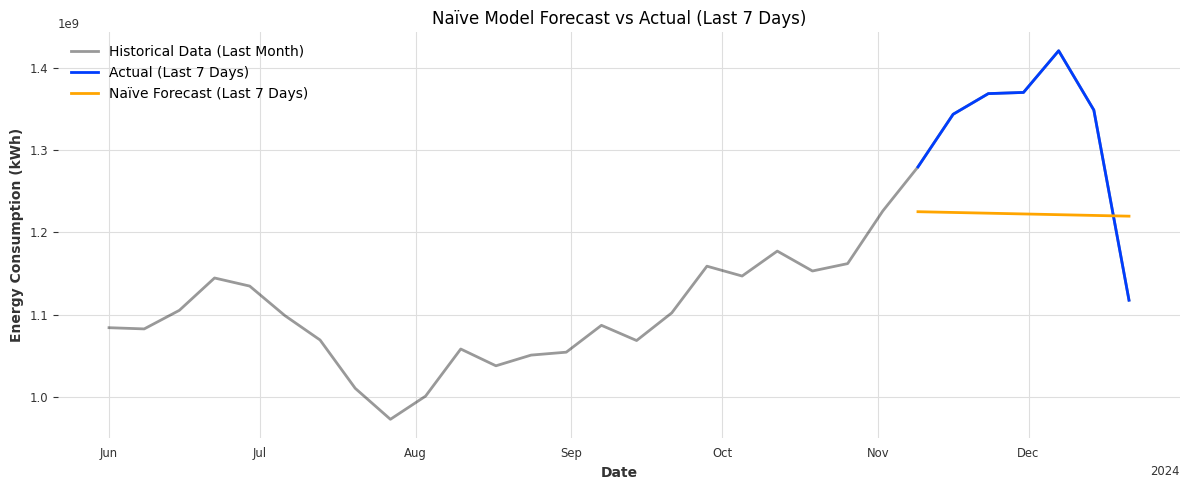

MAPE over last 7 days (Naïve): 9.62%


In [ ]:
from darts.models import NaiveSeasonal
from darts.metrics import mape
import matplotlib.pyplot as plt

# Create full TimeSeries
time_series = TimeSeries.from_times_and_values(time_index[:len(energy_consumption_data)], energy_consumption_data)

# Split: train = everything except last 7 days
train, val = time_series[:-7], time_series[-7:]

# Naïve model (no seasonality, just repeats last observed value)
from darts.models import NaiveDrift

# Naive forecast = last observed value repeated
model = NaiveDrift()
model.fit(train)

# Forecast last 7 days
forecast = model.predict(len(val))

# Plot actual vs forecast
plt.figure(figsize=(12, 5))
time_series[-30:].plot(label="Historical Data (Last Month)", alpha=0.4)
val.plot(label="Actual (Last 7 Days)")
forecast.plot(label="Naïve Forecast (Last 7 Days)", color="orange")
plt.title("Naïve Model Forecast vs Actual (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
error = mape(val, forecast)
print(f"MAPE over last 7 days (Naïve): {error:.2f}%")

# AR 1

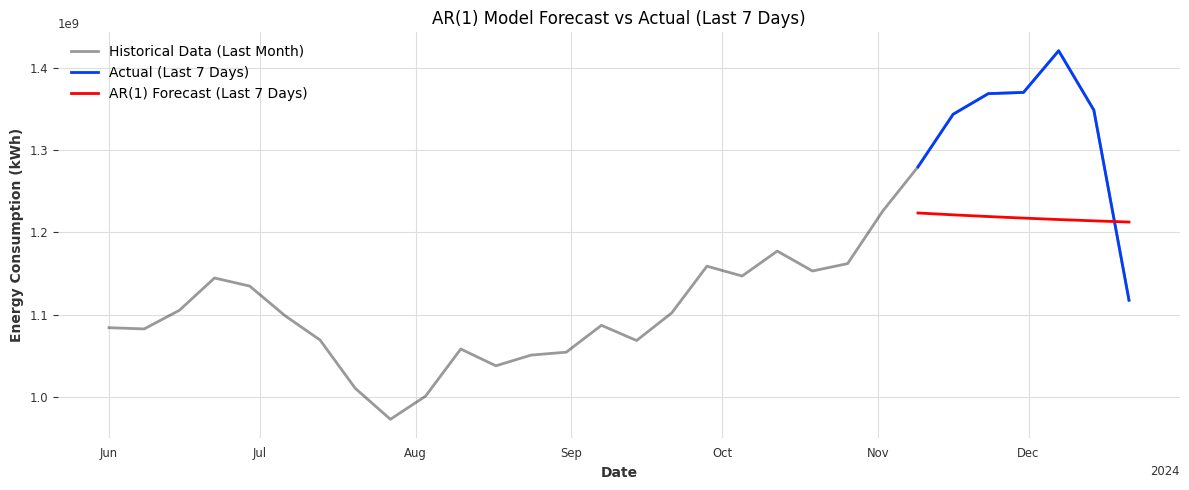

MAPE over last 7 days: 9.80%


In [ ]:
# Create full TimeSeries
time_series = TimeSeries.from_times_and_values(time_index[:len(energy_consumption_data)], energy_consumption_data)

# Split: train = everything except last 7 days
train, val = time_series[:-7], time_series[-7:]

# Fit AR(1) model
model = ARIMA(p=1, d=0, q=0)
model.fit(train)

# Forecast last 7 days
forecast = model.predict(len(val))

# Plot actual vs forecast
plt.figure(figsize=(12, 5))
time_series[-30:].plot(label="Historical Data (Last Month)", alpha=0.4)
val.plot(label="Actual (Last 7 Days)")
forecast.plot(label="AR(1) Forecast (Last 7 Days)", color="red")
plt.title("AR(1) Model Forecast vs Actual (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
error = mape(val, forecast)
print(f"MAPE over last 7 days: {error:.2f}%")


In [ ]:
from darts.models import  NaiveSeasonal

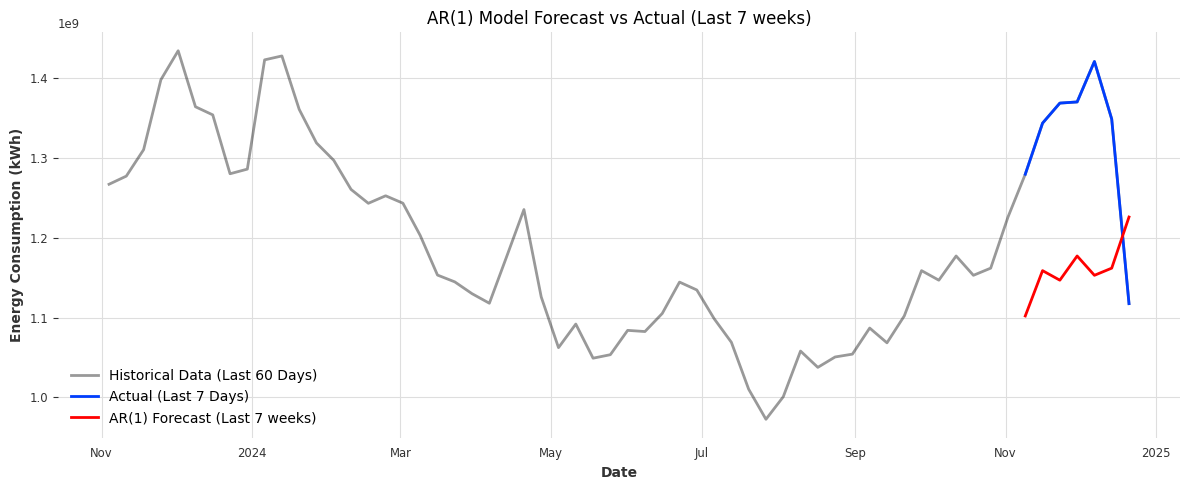

MAPE over last 7 days: 14.35%


In [ ]:
# Create full TimeSeries
time_series = TimeSeries.from_times_and_values(time_index[:len(energy_consumption_data)], energy_consumption_data)

# Split: train = everything except last 7 weeks
train, val = time_series[:-7], time_series[-7:]

# Fit AR(1) model
model = NaiveSeasonal(K=7)
model.fit(train)

# Forecast last 7 weeks
forecast = model.predict(len(val))

# Plot actual vs forecast
plt.figure(figsize=(12, 5))
time_series[-60:].plot(label="Historical Data (Last 60 Days)", alpha=0.4)
val.plot(label="Actual (Last 7 Days)")
forecast.plot(label="AR(1) Forecast (Last 7 weeks)", color="red")
plt.title("AR(1) Model Forecast vs Actual (Last 7 weeks)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate
error = mape(val, forecast)
print(f"MAPE over last 7 days: {error:.2f}%")


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 0, 0)  # AR(1)
horizon = 4             # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(1,0,0), 4-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (4-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly, 4-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")



✅ MAPE (Weekly, 4-week Horizon): 6.23%


Monthly forecast

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 0, 0)  # AR(1)
horizon = 4             # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(5,0,0), 4-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (4-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly, 4-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")



✅ MAPE (Weekly, 4-week Horizon): 6.23%


AR1 8-week horizon

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 0, 0)  # AR(1)
horizon = 8          # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(1,0,0), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (8-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")



✅ MAPE (Weekly, 8-week Horizon): 8.31%


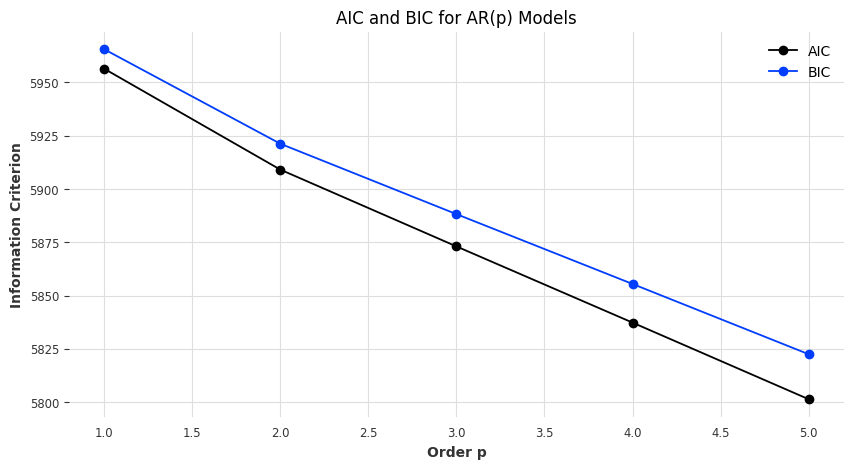

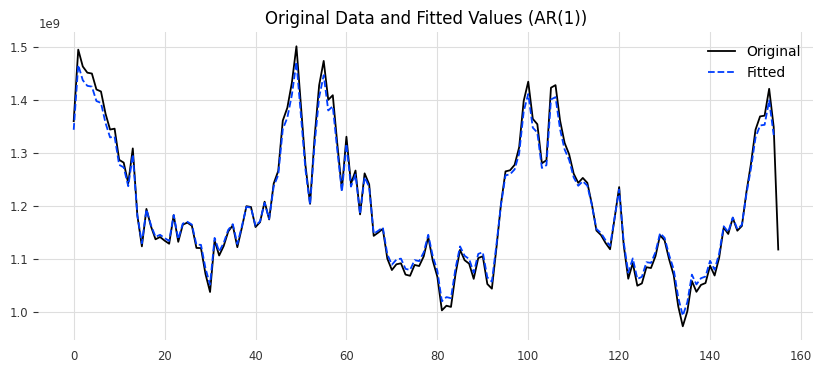

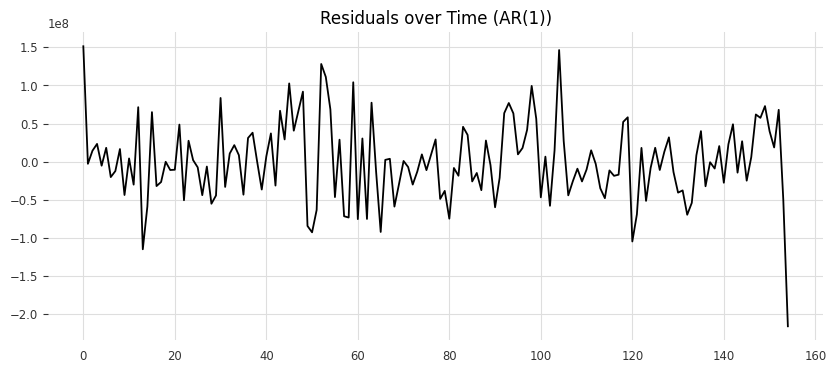

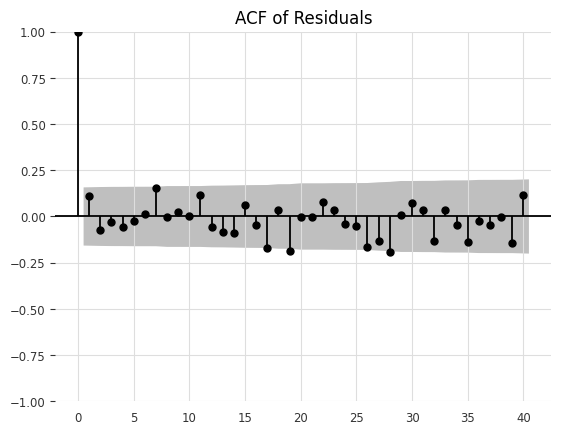

Ljung–Box Test (lag=10):
     lb_stat  lb_pvalue
10  7.646378   0.663334


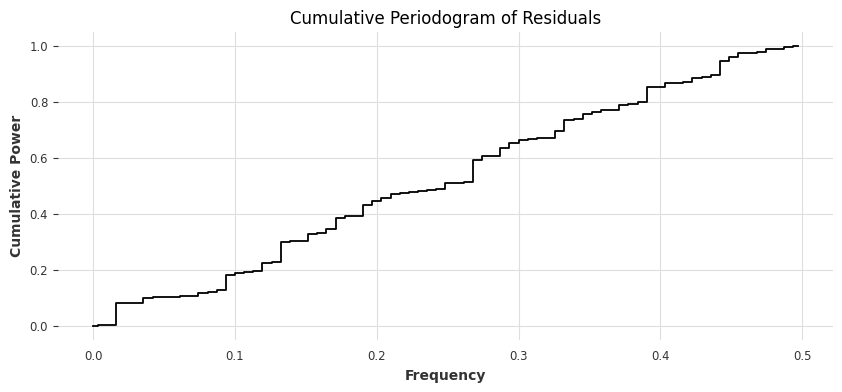

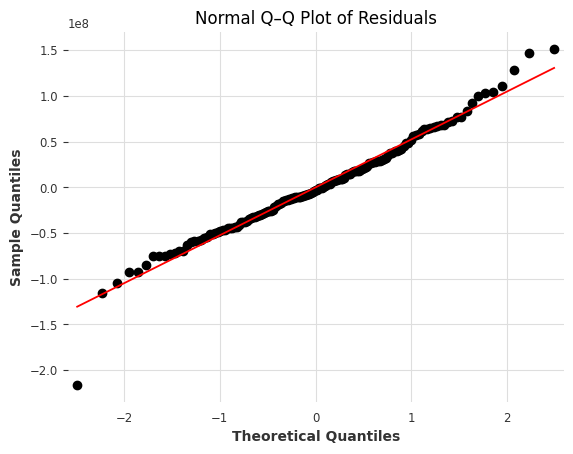

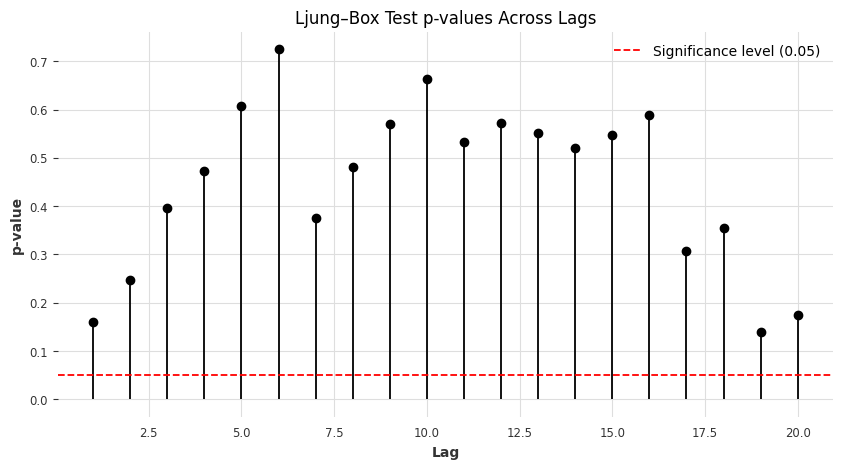


Likelihood Ratio Test (LRT) Results (comparing AR(p) vs AR(p-1)):
AR(2) vs AR(1):  LR stat = 49.369, p-value = 0.0000
AR(3) vs AR(2):  LR stat = 38.044, p-value = 0.0000
AR(4) vs AR(3):  LR stat = 37.772, p-value = 0.0000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from scipy import signal
from scipy.stats import chi2

# Fit AR(1) to AR(5) models and collect AIC, BIC
aic_values = []
bic_values = []
llf_values = []
models = []

for p in range(1, 6):
    model = AutoReg(energy_consumption_data, lags=p, old_names=False).fit()
    models.append(model)
    aic_values.append(model.aic)
    bic_values.append(model.bic)
    llf_values.append(model.llf)

# Likelihood ratio tests: compare AR(p) to AR(p-1)
lr_stats = []
lr_pvals = []
for i in range(1, len(llf_values)):
    stat = 2 * (llf_values[i] - llf_values[i - 1])
    df = models[i].df_model - models[i - 1].df_model
    p_val = chi2.sf(stat, df)
    lr_stats.append(stat)
    lr_pvals.append(p_val)

# Plot AIC and BIC
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), aic_values, marker='o', label='AIC')
plt.plot(range(1, 6), bic_values, marker='o', label='BIC')
plt.title("AIC and BIC for AR(p) Models")
plt.xlabel("Order p")
plt.ylabel("Information Criterion")
plt.legend()
plt.grid(True)
plt.show()

# Choose AR(1) model for diagnostics
best_model = models[0]
residuals = best_model.resid
fitted = best_model.fittedvalues

# Plot 1: Original data and fitted mean
plt.figure(figsize=(10, 4))
plt.plot(energy_consumption_data, label="Original")
plt.plot(fitted, label="Fitted", linestyle='--')
plt.title("Original Data and Fitted Values (AR(1))")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Time series of residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals over Time (AR(1))")
plt.grid(True)
plt.show()

# Plot 3: ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Plot 4: Ljung–Box test
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung–Box Test (lag=10):")
print(ljung_box)

# Plot 5: Cumulative Periodogram
frequencies, power = signal.periodogram(residuals)
cum_power = np.cumsum(power) / np.sum(power)
plt.figure(figsize=(10, 4))
plt.step(frequencies, cum_power, where='mid')
plt.title("Cumulative Periodogram of Residuals")
plt.xlabel("Frequency")
plt.ylabel("Cumulative Power")
plt.grid(True)
plt.show()

# Plot 6: Normal Q–Q plot of residuals
qqplot(residuals, line='s')
plt.title("Normal Q–Q Plot of Residuals")
plt.show()

# Compute Ljung–Box Q-statistics and p-values for multiple lags
max_lag = 20
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, max_lag + 1), return_df=True)

# Plot Q-values or p-values
plt.figure(figsize=(10, 5))
plt.stem(ljung_box_results.index, ljung_box_results['lb_pvalue'], basefmt=" ")
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance level (0.05)')
plt.title("Ljung–Box Test p-values Across Lags")
plt.xlabel("Lag")
plt.ylabel("p-value")
plt.legend()
plt.grid(True)
plt.show()

# Print Likelihood Ratio Test results
print("\nLikelihood Ratio Test (LRT) Results (comparing AR(p) vs AR(p-1)):")
for i in range(1, len(lr_stats)):
    print(f"AR({i+1}) vs AR({i}):  LR stat = {lr_stats[i-1]:.3f}, p-value = {lr_pvals[i-1]:.4f}")



In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 0, 0)  # AR(1)
horizon = 4             # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (AR(1,0,0), 4-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="AR(1,0,0) Rolling Forecast (4-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/AR_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly, 4-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")

✅ MAPE (Weekly, 4-week Horizon): 6.23%


ARIMA

# ARMA

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Forecast (Rolling Forecasts in Weekly Steps) ---
model = ARIMA(1, 1, 0)
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,       # e.g., last year for validation
    forecast_horizon=1,           # forecast 1 week ahead
    stride=1,                     # advance one week at a time
    retrain=True,
    train_length=104              # two years of training data
)

# --- Align actual and forecast series ---
actual = series.slice_intersect(forecast)

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (ARIMA(2,0,0))',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="ARMA(2,1,0) Rolling Forecast (Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


✅ MAPE (Weekly): 3.30%


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 0, 1)  # ARMA(5,0,2) with yearly seasonality
horizon = 4             # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (ARMA(5,2), 4-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="ARMA(5,2) Rolling Forecast (4-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_model.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"\u2705 MAPE (Weekly, 4-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("\u26A0\ufe0f Forecast and actual series do not match in length.")


✅ MAPE (Weekly, 4-week Horizon): 6.25%


ARMA 8-week horizon

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(2, 0, 1)  # ARMA(5,0,2) with yearly seasonality
horizon = 8            # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (ARMA(2,2), 8-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="ARMA(5,2) Rolling Forecast (8-week Horizon, Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_model.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"\u2705 MAPE (Weekly, 8-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("\u26A0\ufe0f Forecast and actual series do not match in length.")


✅ MAPE (Weekly, 8-week Horizon): 8.25%


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings
from functools import reduce

warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Training and prediction settings ---
horizon = 8                    # forecast 4 steps ahead
train_len = 104                # 2 years of training
start_idx = len(series) - 52  # last 1 year

# --- Containers for predicted and actual values ---
predicted = []
actual_vals = []

# --- Initialize model ---
model = ARIMA(2, 0, 1)

for i in range(start_idx, len(series) - horizon):
    train_series = series[i - train_len:i]
    true_future = series[i:i + horizon]

    # Fit on real past
    model.fit(train_series)

    # Start recursive prediction
    history = train_series
    preds = []

    for _ in range(horizon):
        pred = model.predict(1)
        preds.append(pred)
        # Use prediction as next input (student forcing)
        history = history.append(pred)
        model.fit(history)  # optional: re-fit at each step (slower, more adaptive)

    # Collect the last prediction and the actual corresponding value
    predicted.append(preds[-1])  # Only use the final step of horizon
    actual_vals.append(true_future[-1])

# --- Stack to TimeSeries ---
forecast = reduce(lambda a, b: a.concatenate(b), predicted)
actual = reduce(lambda a, b: a.concatenate(b), actual_vals)

# --- Convert to Pandas ---
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Student-Forced Forecast (Recursive ARMA (1,1))',
    line=dict(color='red')
))

fig.update_layout(
    title="Student Forcing Forecast (ARMA Recursive(1,1), 4-week Horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

fig.show()

# --- Save ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/ARMA_data.json",
    pretty=True
)

# --- MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Student Forcing, Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


✅ MAPE (Student Forcing, Weekly): 8.29%


# ARIMA

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Forecast (Rolling Forecasts in Weekly Steps) ---
model = ARIMA(2, 1, 1)
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,       # e.g., last year for validation
    forecast_horizon=1,           # forecast 1 week ahead
    stride=1,                     # advance one week at a time
    retrain=True,
    train_length=104              # two years of training data
)

# --- Align actual and forecast series ---
actual = series.slice_intersect(forecast)

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (ARIMA(2,1,1))',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="ARIMA(5,0,2) Rolling Forecast (Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/ARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


✅ MAPE (Weekly): 3.33%


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings

# Optional: suppress convergence warnings
warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Multi-Step Forecast (Horizon = 4 weeks) ---
model = ARIMA(1, 1, 1)  # ARIMA(5,0,2) with yearly seasonality
horizon = 4             # forecast 4 steps ahead
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,  # start 1 year before end
    forecast_horizon=horizon,
    stride=1,
    retrain=True,
    train_length=104,        # train on 2 years
    last_points_only=True    # return only the final forecast point
)

# --- Align actual values ---
actual = series.slice(forecast.start_time(), forecast.end_time())

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (ARIMA(1,1,1), 4-week horizon)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="ARIMA(1,1,1) Rolling Forecast (4-week Horizon, Weekly) (not used since ts stationnary)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/ARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"\u2705 MAPE (Weekly, 4-week Horizon): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("\u26A0\ufe0f Forecast and actual series do not match in length.")


✅ MAPE (Weekly, 4-week Horizon): 7.00%


# SARIMA

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Fit ARIMA and Forecast (Rolling Forecasts in Weekly Steps) ---
model = ARIMA(2, 1, 0, seasonal_order=(1, 0, 1, 11))
forecast = model.historical_forecasts(
    series=series,
    start=len(series) - 52,       # e.g., last year for validation
    forecast_horizon=1,           # forecast 1 week ahead
    stride=1,                     # advance one week at a time
    retrain=True,
    train_length=104              # two years of training data
)

# --- Align actual and forecast series ---
actual = series.slice_intersect(forecast)

# Convert to Pandas
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot with Plotly ---
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

# Forecast values
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Rolling Forecasted Weekly (SARIMA(2,1,1) with (1,0,10) as seasonal component)',
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="SARIMA(2,1,0), with 10-week non differenced seasonal component Rolling Forecast (Weekly)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

# Show plot
fig.show()

# --- Save JSON for Next.js ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/SARIMA_data.json",
    pretty=True
)

# --- Evaluate and save MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


✅ MAPE (Weekly): 3.29%


In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mape
import plotly.graph_objects as go
import plotly.io as pio
import warnings
from functools import reduce

warnings.filterwarnings("ignore")

# --- Load or define your data ---
# df = pd.read_csv("your_data.csv")
# time_index = pd.to_datetime(df["date"])
# energy_consumption_data = df["kwh"]

# Ensure consistent lengths
min_len = min(len(time_index), len(energy_consumption_data))
time_index = time_index[:min_len]
energy_consumption_data = energy_consumption_data[:min_len]

# --- Convert to Darts TimeSeries (WEEKLY) ---
series = TimeSeries.from_times_and_values(
    pd.DatetimeIndex(time_index),
    energy_consumption_data,
    fill_missing_dates=True,
)

# --- Training and prediction settings ---
horizon = 4                    # forecast 4 steps ahead
train_len = 104                # 2 years of training
start_idx = len(series) - 52  # last 1 year

# --- Containers for predicted and actual values ---
predicted = []
actual_vals = []

# --- Initialize model ---
model = ARIMA(1, 0, 1, seasonal_order=(1,0,1,10))

for i in range(start_idx, len(series) - horizon):
    train_series = series[i - train_len:i]
    true_future = series[i:i + horizon]

    # Fit on real past
    model.fit(train_series)

    # Start recursive prediction
    history = train_series
    preds = []

    for _ in range(horizon):
        pred = model.predict(1)
        preds.append(pred)
        # Use prediction as next input (student forcing)
        history = history.append(pred)
        model.fit(history)  # optional: re-fit at each step (slower, more adaptive)

    # Collect the last prediction and the actual corresponding value
    predicted.append(preds[-1])  # Only use the final step of horizon
    actual_vals.append(true_future[-1])

# --- Stack to TimeSeries ---
forecast = reduce(lambda a, b: a.concatenate(b), predicted)
actual = reduce(lambda a, b: a.concatenate(b), actual_vals)

# --- Convert to Pandas ---
actual_df = actual.pd_series().to_frame(name="Actual")
forecast_df = forecast.pd_series().to_frame(name="Forecast")

# --- Plot ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=actual_df.index,
    y=actual_df["Actual"],
    mode='lines+markers',
    name='Actual Weekly',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Forecast"],
    mode='lines+markers',
    name='Student-Forced Forecast (Recursive ARMA (1,1))',
    line=dict(color='red')
))

fig.update_layout(
    title="Student Forcing Forecast (ARMA Recursive with 10th week seasonality, 4-week Horizon)",
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
    legend=dict(x=0, y=1),
    template="plotly_dark",
    width=1000,
    height=500
)

fig.show()

# --- Save ---
pio.write_json(
    fig,
    "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/SARIMA_data.json",
    pretty=True
)

# --- MAPE ---
if len(actual) == len(forecast):
    mape_score = mape(actual, forecast)
    print(f"✅ MAPE (Student Forcing, Weekly): {mape_score:.2f}%")

    with open("/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt", "w") as f:
        f.write(f"{mape_score:.2f}")
else:
    print("⚠️ Forecast and actual series do not match in length.")


✅ MAPE (Student Forcing, Weekly): 6.20%


In [ ]:
from pmdarima import auto_arima

auto_model = auto_arima(train.values(), seasonal=False, max_p=5, max_q=5)
print(auto_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2831.855
Date:                Mon, 09 Jun 2025   AIC                           5667.711
Time:                        12:44:07   BIC                           5673.705
Sample:                             0   HQIC                          5670.146
                                - 149                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0980      0.070      1.397      0.162      -0.039       0.235
sigma2      2.499e+15   4.24e-18   5.89e+32      0.000     2.5e+15     2.5e+15
Ljung-Box (L1) (Q):                   0.17   Jarque-

In [ ]:
df = df_backup

In [ ]:
from sklearn.preprocessing import StandardScaler
from darts.metrics import mape

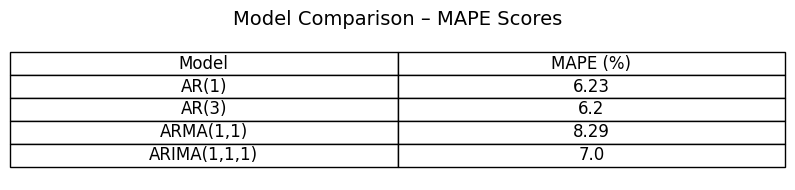

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths and model names
models = {
    "AR(1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/AR/ar_mape.txt",
        "AR(3)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/SARIMA/sarima_mape.txt",
    "ARMA(1,1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARMA/arma_mape.txt",
    "ARIMA(1,1,1)": "/Users/omarabdesslem/Documents/Projects/Thesis-Website/public/ARIMA/arima_mape.txt",
}

# Read MAPE values
mape_scores = {}
for model_name, path in models.items():
    try:
        with open(path, "r") as f:
            mape_scores[model_name] = float(f.read().strip())
    except Exception as e:
        mape_scores[model_name] = None
        print(f"⚠️ Could not read MAPE for {model_name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(list(mape_scores.items()), columns=["Model", "MAPE (%)"])

# Plot as a clean table
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis("off")
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("Model Comparison – MAPE Scores", fontsize=14, pad=10)
plt.tight_layout()
plt.show()

